<a href="https://colab.research.google.com/github/KhayalM/Extended-Finite-Element-Methods-Second-Part/blob/main/Disc_0_75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%reset -f

# 1. Mesh creation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.special import lambertw
import matplotlib.animation as animation
from scipy.optimize import fsolve
from scipy.sparse.linalg import cg, gmres
from scipy.linalg import cho_factor, cho_solve
import warnings
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

In [6]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import gmsh
else:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

--2026-01-12 20:24:07--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2026-01-12 20:24:07 (44.1 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/2ffb5740/releases/h5py-install.sh
+ [[ https://gith

In [7]:
# ==========================================================
# 1. GEOMETRY AND MESH GENERATION
# ==========================================================
gmsh.initialize()
gmsh.model.add("2D_Rod")

# Parameters
lc = 0.75
L, H = 1.0, 1.0

# Points
gmsh.model.geo.addPoint(0.0, 0.0, 0.0, lc, 1)  # BL
gmsh.model.geo.addPoint(L,   0.0, 0.0, lc, 2)  # BR
gmsh.model.geo.addPoint(L,   H,   0.0, lc, 3)  # TR
gmsh.model.geo.addPoint(0.0, H,   0.0, lc, 4)  # TL

# Lines
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)

# Surface
curve_loop = gmsh.model.geo.addCurveLoop([1, 2, 3, 4])
rod_surface = gmsh.model.geo.addPlaneSurface([curve_loop])

gmsh.model.geo.synchronize()

# Physical Groups (Tags)
# 2D Domain
gmsh.model.addPhysicalGroup(2, [rod_surface], 1)
gmsh.model.setPhysicalName(2, 1, "Rod")

# 1D Boundaries
gmsh.model.addPhysicalGroup(1, [4], 101)  # Left edge
gmsh.model.setPhysicalName(1, 101, "Left")
gmsh.model.addPhysicalGroup(1, [2], 102)  # Right edge
gmsh.model.setPhysicalName(1, 102, "Right")

# Generate Mesh
gmsh.option.setNumber("Mesh.ElementOrder", 1)  # Linear triangles
gmsh.option.setNumber("Mesh.Algorithm", 6)     # Delaunay
gmsh.model.mesh.generate(2)

# Optional: Save to disk (but we won't read it back in this script)
gmsh.write("rod_2D.msh")


# ==========================================================
# 2. DATA EXTRACTION (Direct from Memory)
# ==========================================================

# Helper to get nodes for a specific physical group
def get_nodes_from_physical_group(dim, tag):
    node_ids = set()
    entity_tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
    for entity in entity_tags:
        _, _, node_tags = gmsh.model.mesh.getElements(dim, entity)
        for conn in node_tags:
            node_ids.update(conn)
    return np.array(list(node_ids), dtype=int) - 1  # Convert to 0-based

# --- 1. Get All Nodes ---
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
nodes = np.array(node_coords).reshape(-1, 3)[:, :2] # Keep (x, y)

# --- 2. Get 2D Elements (Triangles) ---
# Get entities associated with Physical Group 1 ("Rod")
rod_entities = gmsh.model.getEntitiesForPhysicalGroup(2, 1)
element_connectivity = []

for entity in rod_entities:
    # Get elements for this entity
    _, _, node_tags_list = gmsh.model.mesh.getElements(2, entity)
    for tags in node_tags_list:
        element_connectivity.append(np.array(tags).reshape(-1, 3))

elements = np.concatenate(element_connectivity) - 1 # Convert to 0-based

# --- 3. Get Boundary Nodes (Indices) ---
left_nodes_idx = get_nodes_from_physical_group(1, 101)
right_nodes_idx = get_nodes_from_physical_group(1, 102)

# Done with Gmsh
gmsh.finalize()

In [8]:
# ==========================================================
# 3. PROPERTIES AND PLOTTING
# ==========================================================

# Material & BC Definitions
# Material & BC Definitions
E = 26e9
nu = 0.2
sigma_y = 2e6
G_f = 740
prescribed_disp = 1e-3

In [9]:
boundary_conditions = [

    # Left edge: x = 0 → ux = 0, uy free
    [[[0.0, 0.0], [0.0, H]], 'U', 0.0, "free"],

    # Bottom edge: y = 0 → uy = 0, ux free
    [[[0.0, 0.0], [L, 0.0]], 'U', "free", 0.0],

    # Right edge: x = 5 → prescribed elongation
    [[[L, 0.0], [L, H]], 'U', 1e-3, "free"],
]


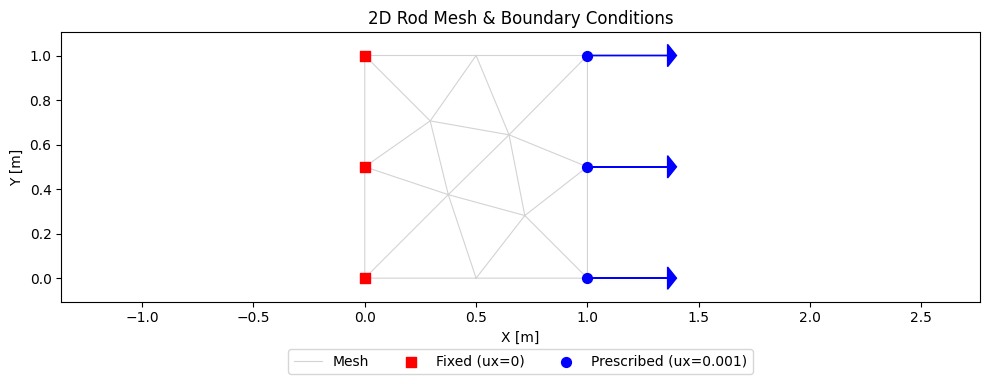

In [10]:
x = nodes[:, 0]
y = nodes[:, 1]
rod_height = np.max(y) - np.min(y)

plt.figure(figsize=(10, 4))

# --- Plot Mesh ---
plt.triplot(x, y, elements, color="lightgray", linewidth=0.8, label="Mesh")

# --- Plot Fixed Boundary (Left) ---
plt.scatter(x[left_nodes_idx], y[left_nodes_idx],
            color="red", marker="s", s=60, label="Fixed (ux=0)")

# --- Plot Prescribed Boundary (Right) ---
plt.scatter(x[right_nodes_idx], y[right_nodes_idx],
            color="blue", marker="o", s=50, label=f"Prescribed (ux={prescribed_disp})")

# --- Visual Arrows ---
arrow_len = 0.4 * rod_height
for n in right_nodes_idx:
    plt.arrow(x[n], y[n], arrow_len, 0.0,
              head_width=0.1*rod_height, head_length=0.04*rod_height,
              fc="blue", ec="blue", length_includes_head=True)

# --- Annotations ---
plt.title("2D Rod Mesh & Boundary Conditions")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()

# 2. FEM

## 2.1 Functions

In [11]:
def area(element):
    """
    Compute the area of a triangular Constant Strain Triangle (CST) element.

    element : array-like of length 3
        Indices of the triangle nodes in the global 'nodes' array
    """

    # Extract coordinates of the three nodes
    x1, y1 = nodes[element[0]]
    x2, y2 = nodes[element[1]]
    x3, y3 = nodes[element[2]]

    # Determinant-based formula for triangle area
    return abs(
        x1*(y2 - y3) +
        x2*(y3 - y1) +
        x3*(y1 - y2)
    ) / 2.0

In [12]:
def cyclic_permutation(element):
    """
    Perform a cyclic permutation of an element's nodes.

    [n1, n2, n3] → [n2, n3, n1]
    """
    return np.array([element[1], element[2], element[0]])

In [13]:
def N(element, x, y):
    """
    Compute the CST shape function matrix [N] at point (x, y).

    N has size (2 × 6) for a triangular element:
    [ u ] = [N] [u1 v1 u2 v2 u3 v3]^T
    [ v ]
    """

    # Initialize shape function matrix
    Nmat = np.zeros((2, 2 * len(element)))

    # Area of the triangle
    A = area(element)

    # Local copy of element node ordering
    elem = element.copy()

    for i in range(len(elem)):
        # Coordinates for cyclically permuted nodes
        x1, y1 = nodes[elem[0]]
        x2, y2 = nodes[elem[1]]
        x3, y3 = nodes[elem[2]]

        # CST coefficients
        ai = x2*y3 - x3*y2
        bi = y2 - y3
        ci = x3 - x2

        # Shape function Ni(x, y)
        Ni = (ai + bi*x + ci*y) / (2*A)

        # Place Ni in displacement interpolation matrix
        Nmat[0, 2*i]     = Ni   # u component
        Nmat[1, 2*i + 1] = Ni   # v component

        # Rotate nodes for next shape function
        elem = cyclic_permutation(elem)

    return Nmat

In [14]:
def B(element):
    """
    Compute the CST strain–displacement matrix [B].

    B maps nodal displacements to constant strains:
    ε = B * u
    """

    # Initialize B matrix (3 strains × 6 DOFs)
    Bmat = np.zeros((3, 2 * len(element)))

    # Element area
    A = area(element)

    # Local copy of node ordering
    elem = element.copy()

    for i in range(len(elem)):
        # Coordinates after cyclic permutation
        x1, y1 = nodes[elem[0]]
        x2, y2 = nodes[elem[1]]
        x3, y3 = nodes[elem[2]]

        # Fill B matrix entries
        Bmat[0, 2*i]     = (y2 - y3)  # ε_xx
        Bmat[1, 2*i + 1] = (x3 - x2)  # ε_yy
        Bmat[2, 2*i]     = (x3 - x2)  # γ_xy
        Bmat[2, 2*i + 1] = (y2 - y3)

        # Rotate nodes
        elem = cyclic_permutation(elem)

    # Normalize by 2A
    return Bmat / (2*A)

In [15]:
def C(E, nu):
    """
    Isotropic plane strain constitutive matrix.

    E  : Young's modulus
    nu : Poisson's ratio
    """
    return (E / ((1 + nu)*(1 - 2*nu))) * np.array([
        [1 - nu,  nu,        0],
        [nu,      1 - nu,    0],
        [0,       0, (1 - 2*nu)/2]
    ])

In [16]:
def node_in_segment(node, segment, tol=1e-10):
    """
    Check if a node lies on a boundary segment.

    node    : node index
    segment : [[x1,y1], [x2,y2]]
    tol     : numerical tolerance
    """

    # Node coordinates
    p = nodes[node]

    # Segment endpoints
    a = np.array(segment[0])
    b = np.array(segment[1])

    # Collinearity check using 2D cross product
    cross = np.cross(p - b, a - b)
    if abs(cross) > tol:
        return False

    # Check if point lies within segment bounding box
    if (min(a[0], b[0]) - tol <= p[0] <= max(a[0], b[0]) + tol and
        min(a[1], b[1]) - tol <= p[1] <= max(a[1], b[1]) + tol):
        return True

    return False

In [17]:
def compute_strains(elements, u):
    """
    Compute constant strain for each CST element.

    elements : list of triangular elements (each with 3 node indices)
    u        : global displacement vector
               [u0, v0, u1, v1, ..., uN, vN]
    """

    # Strain array:
    # one row per element, three strain components per element
    # [ε_xx, ε_yy, γ_xy]
    epsilon = np.zeros((len(elements), 3))

    # Loop over all elements
    for i, element in enumerate(elements):

        # Extract element displacement vector u_e (size 6×1)
        # Ordering: [u1, v1, u2, v2, u3, v3]
        u_e = np.array(
            [u[2*node + dof] for node in element for dof in (0, 1)]
        )

        # Compute constant strain using ε = B * u_e
        epsilon[i] = B(element) @ u_e

    return epsilon

In [18]:
def compute_stress(elements, u):
    """
    Compute stress vector for each CST element.

    elements : list of triangular elements
    u        : global displacement vector
    """

    # First compute strains for all elements
    epsilon = compute_strains(elements, u)

    # Initialize stress array (same size as strain array)
    sigma = np.zeros_like(epsilon)

    # Constitutive matrix (plane strain)
    C_mat = C(E, nu)

    # Loop over elements
    for i in range(len(epsilon)):

        # Apply Hooke's law: σ = C * ε
        sigma[i] = C_mat @ epsilon[i]

    return sigma

## 2.2 Assembly

In [19]:
def assembly(elements):
    """
    Assemble:
    - global stiffness matrix K
    - global displacement vector u (with prescribed values)
    - global force vector F (zero, since no force BCs)

    Only displacement (Dirichlet) boundary conditions are considered.
    """

    # ------------------------------
    # Global problem size
    # ------------------------------
    n_nodes = len(nodes)          # number of mesh nodes
    n_dofs  = 2 * n_nodes         # 2 DOFs per node (u, v)

    # Initialize global matrices/vectors
    K = np.zeros((n_dofs, n_dofs))  # global stiffness matrix
    F = np.zeros(n_dofs)            # global force vector (always zero here)
    u = np.zeros(n_dofs)            # global displacement vector

    # Constitutive (material) matrix
    C_mat = C(E, nu)

    # ------------------------------
    # Element loop: stiffness assembly
    # ------------------------------
    for element in elements:

        # Strain–displacement matrix (constant for CST)
        B_mat = B(element)

        # Element area
        A = area(element)

        # Element stiffness matrix:
        # K_e = A * (B^T * C * B)
        K_e = A * (B_mat.T @ C_mat @ B_mat)

        # Global DOF indices for this element
        # [u1, v1, u2, v2, u3, v3]
        element_dofs = np.array(
            [2*node + dof for node in element for dof in (0, 1)]
        )

        # Assemble element stiffness into global stiffness matrix
        K[np.ix_(element_dofs, element_dofs)] += K_e

    # ------------------------------
    # Displacement boundary conditions (Dirichlet)
    # ------------------------------
    for segment, bc_type, ux, uy in boundary_conditions:

        # We only handle displacement BCs
        if bc_type != 'U':
            continue

        # Loop over all nodes
        for n in range(n_nodes):

            # Check if node lies on the boundary segment
            if node_in_segment(n, segment):

                # Prescribed x-displacement
                if ux != "free":
                    u[2*n] = ux

                # Prescribed y-displacement
                if uy != "free":
                    u[2*n + 1] = uy

    # K : global stiffness matrix
    # F : zero force vector
    # u : displacement vector with prescribed values filled in
    return K, F, u

## 2.3 Solver

In [20]:
def split_problem():
    """
    Identify:
    - total degrees of freedom (DOFs)
    - DOFs with prescribed displacements
    - DOFs with unknown (free) displacements
    """

    # Number of nodes and total DOFs
    n_nodes = len(nodes)
    n_dofs  = 2 * n_nodes   # 2 DOFs per node (u, v)

    # List of all DOFs: [0, 1, 2, ..., n_dofs-1]
    total_dofs = list(range(n_dofs))

    # Set for imposed displacement DOFs (use set to avoid duplicates)
    imposed_displacement_dofs = set()

    # Loop over all boundary condition definitions
    for segment, bc_type, ux, uy in boundary_conditions:

        # Only displacement boundary conditions
        if bc_type != 'U':
            continue

        # Loop over all nodes
        for n in range(n_nodes):

            # Check if node belongs to the boundary segment
            if node_in_segment(n, segment):

                # Prescribed x-displacement
                if ux != "free":
                    imposed_displacement_dofs.add(2*n)

                # Prescribed y-displacement
                if uy != "free":
                    imposed_displacement_dofs.add(2*n + 1)

    # Convert to sorted list for consistent ordering
    imposed_displacement_dofs = sorted(imposed_displacement_dofs)

    # Free DOFs = total DOFs − imposed DOFs
    displacement_free_dofs = [
        d for d in total_dofs if d not in imposed_displacement_dofs
    ]

    return total_dofs, imposed_displacement_dofs, displacement_free_dofs

In [21]:
def linear_solver(elements, nodes, K, F, u):
    """
    Solve the linear FEM system with displacement-controlled BCs.

    K : global stiffness matrix
    F : global force vector (zero externally)
    u : global displacement vector with prescribed values
    """

    # Split DOFs into free and prescribed sets
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    # Work on copies to preserve original data
    K_mat = K.copy()
    F_vec = F.copy()
    u_vec = u.copy()

    # ----------------------------------------
    # Block matrices according to DOF splitting
    # ----------------------------------------

    # Free-free stiffness matrix
    K_uu = K_mat[np.ix_(displacement_free_dofs, displacement_free_dofs)]

    # Free–prescribed coupling
    K_up = K_mat[np.ix_(displacement_free_dofs, imposed_displacement_dofs)]

    # Prescribed–free coupling
    K_pu = K_mat[np.ix_(imposed_displacement_dofs, displacement_free_dofs)]

    # Prescribed–prescribed stiffness matrix
    K_pp = K_mat[np.ix_(imposed_displacement_dofs, imposed_displacement_dofs)]

    # ----------------------------------------
    # Solve for unknown displacements
    # ----------------------------------------
    # K_uu * u_f = F_f - K_up * u_p

    u_vec[displacement_free_dofs] = spsolve(
        csc_matrix(K_uu),
        F_vec[displacement_free_dofs] - K_up @ u_vec[imposed_displacement_dofs]
    )

    # ----------------------------------------
    # Compute reaction forces at prescribed DOFs
    # ----------------------------------------
    # F_p = K_pu * u_f + K_pp * u_p

    F_vec[imposed_displacement_dofs] = (
        K_pu @ u_vec[displacement_free_dofs]
        + K_pp @ u_vec[imposed_displacement_dofs]
    )

    return K_mat, F_vec, u_vec

## 2.4 Results of displacement field

In [22]:
# Assembly
K, F_prescribed, u_prescribed = assembly(elements)

# Solve
K, F, u = linear_solver(elements, nodes, K, F_prescribed, u_prescribed)

/tmp/ipython-input-153646867.py:18: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p - b, a - b)


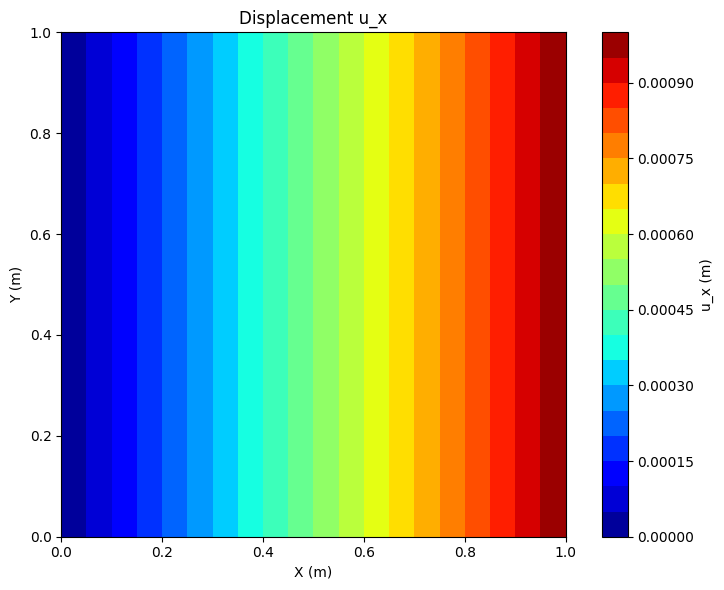

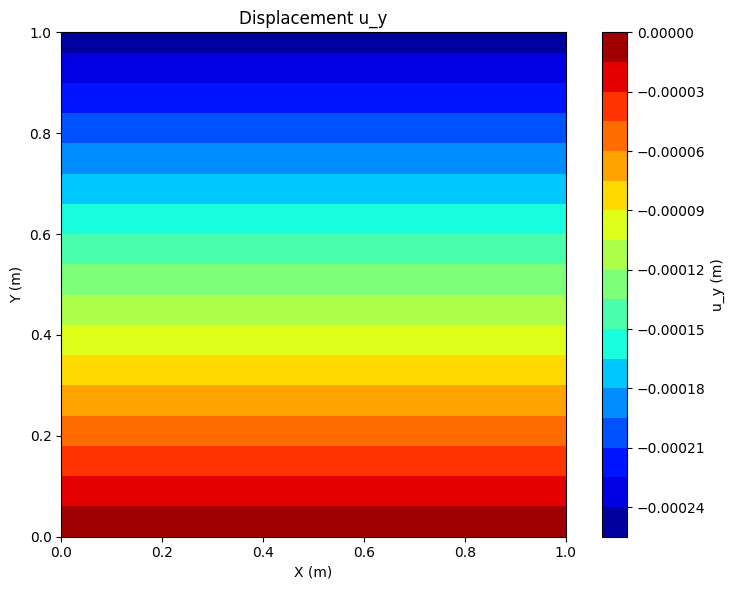

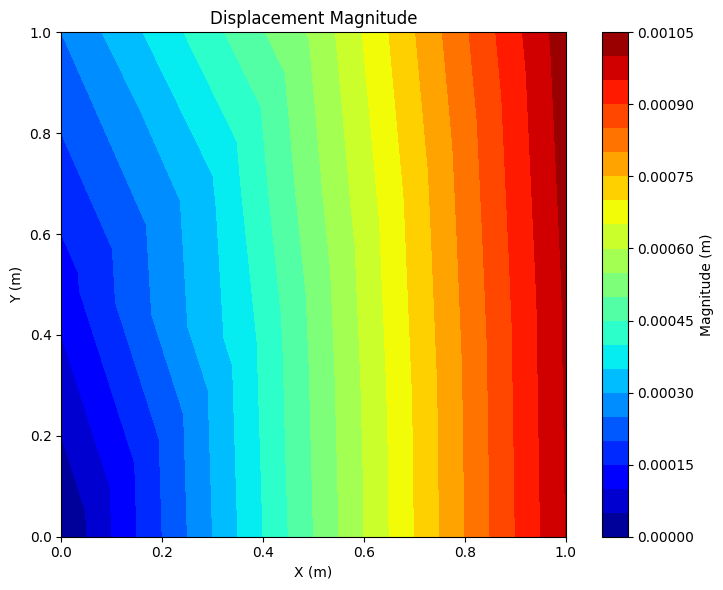

In [23]:
import matplotlib.tri as tri

# ==========================================================
# CREATE TRIANGULATION
# ==========================================================
triangulation = tri.Triangulation(
    nodes[:, 0],
    nodes[:, 1],
    elements
)

# ==========================================================
# NODAL DISPLACEMENT COMPONENTS
# ==========================================================
u_x = u[0::2]
u_y = u[1::2]
u_magnitude = np.sqrt(u_x**2 + u_y**2)

# ==========================================================
# PLOT DISPLACEMENTS (NODAL INTERPOLATED)
# ==========================================================
disp_labels = ['u_x', 'u_y', 'Magnitude']
disp_values = [u_x, u_y, u_magnitude]

for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triangulation, disp_values[i], levels=20, cmap='jet')
    plt.colorbar(label=disp_labels[i] + ' (m)')
    plt.title(f'Displacement {disp_labels[i]}')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()


## 2.5 Results of Stress and Strain fields

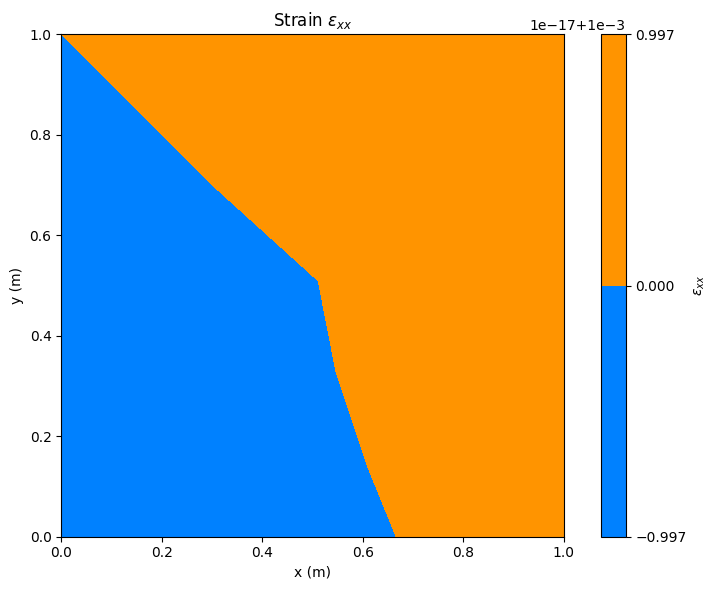

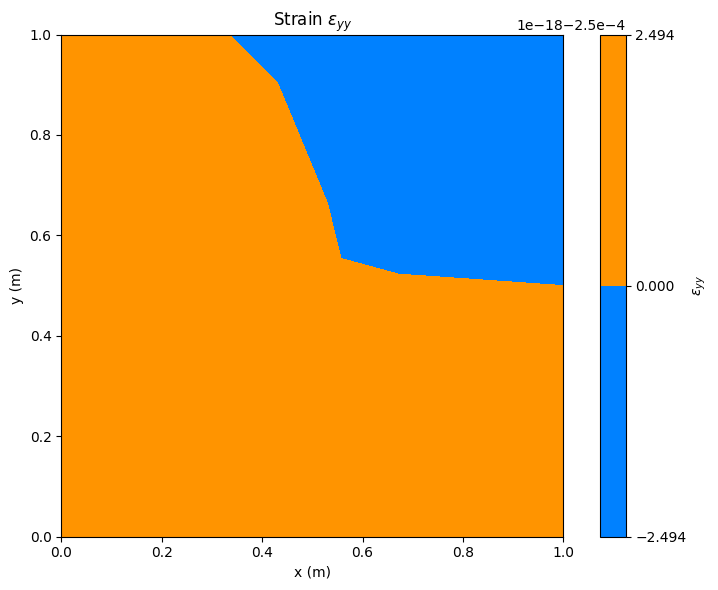

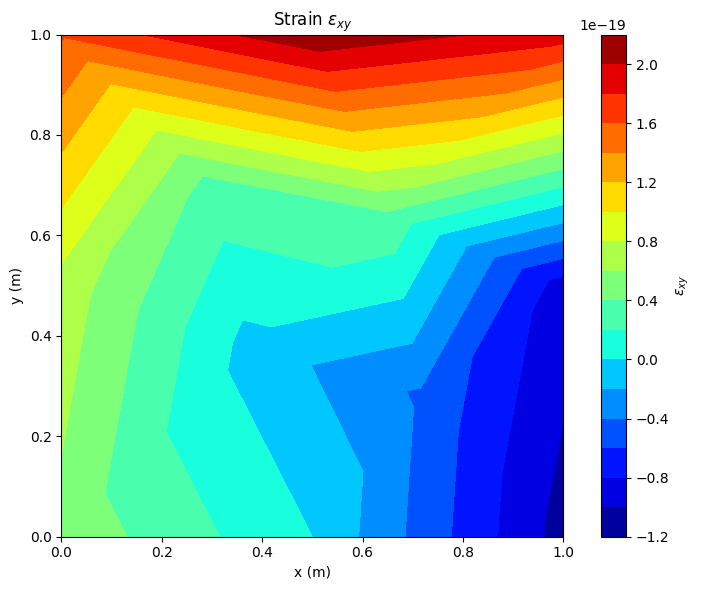

In [24]:
import matplotlib.tri as tri

# ==========================================================
# COMPUTE STRAINS (ELEMENT-WISE)
# ==========================================================
epsilon = compute_strains(elements, u)  # shape (n_elem, 3)
# epsilon[:,0] = ε_xx
# epsilon[:,1] = ε_yy
# epsilon[:,2] = ε_xy

# ==========================================================
# INTERPOLATE STRAINS AT NODES
# ==========================================================
n_nodes = nodes.shape[0]
node_strains = np.zeros((n_nodes, 3))
node_counts = np.zeros(n_nodes)

for i, element in enumerate(elements):
    for node in element:
        node_strains[node] += epsilon[i]
        node_counts[node] += 1

node_strains /= node_counts[:, np.newaxis]  # average over connected elements

# ==========================================================
# CREATE TRIANGULATION
# ==========================================================
triangulation = tri.Triangulation(
    nodes[:, 0],
    nodes[:, 1],
    elements
)

# ==========================================================
# PLOT STRAINS (NODAL INTERPOLATED)
# ==========================================================
strain_labels = [r"$\varepsilon_{xx}$", r"$\varepsilon_{yy}$", r"$\varepsilon_{xy}$"]

for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triangulation, node_strains[:, i], levels=20, cmap='jet')
    plt.colorbar(label=strain_labels[i])
    plt.title(f"Strain {strain_labels[i]}")
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()


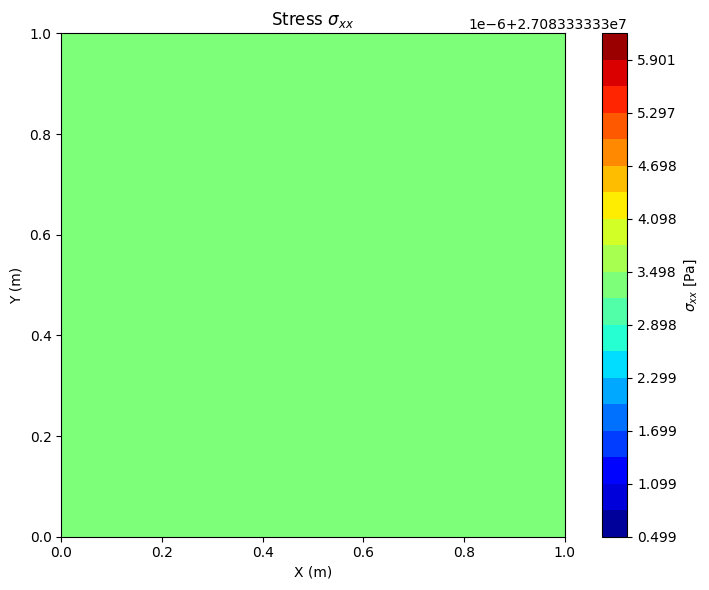

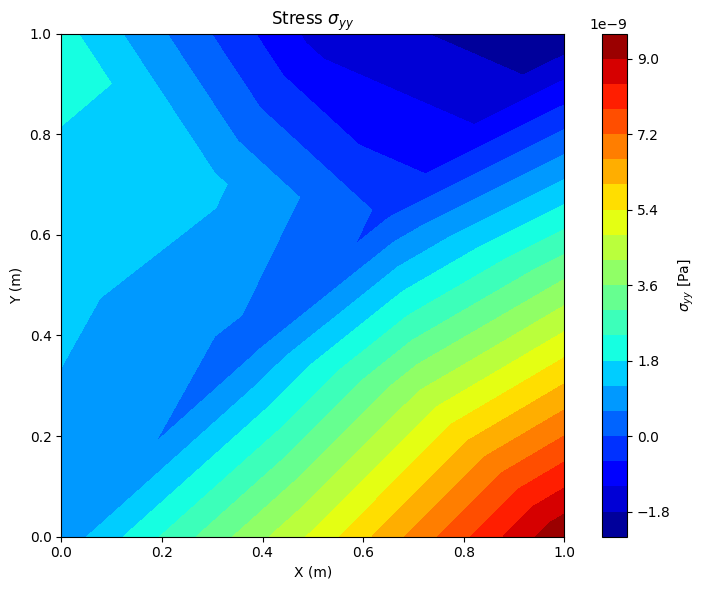

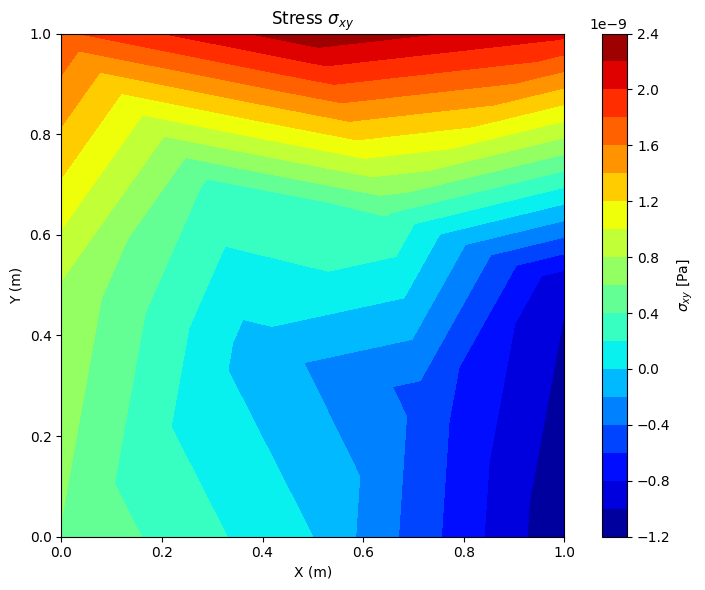

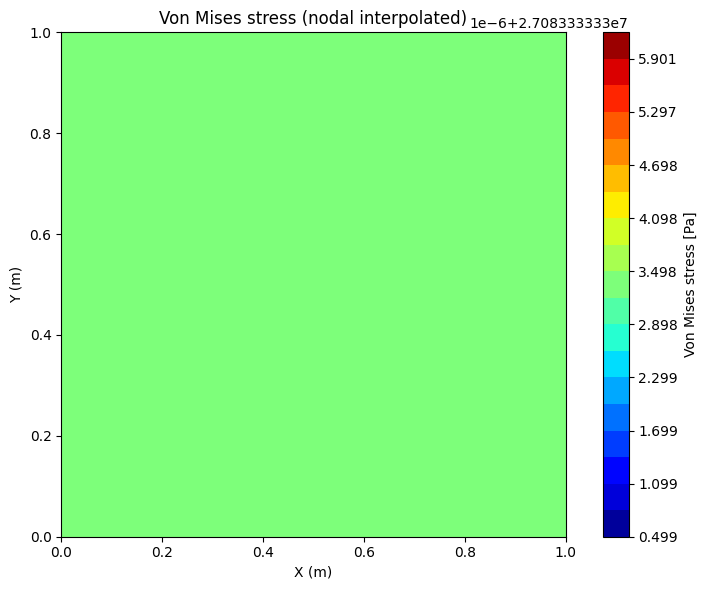

In [25]:
import matplotlib.tri as tri

# ==========================================================
# COMPUTE STRESS AND VON MISES (ELEMENT-WISE)
# ==========================================================
sigma = compute_stress(elements, u)  # shape (n_elem, 3)
# sigma[:,0] = σ_xx
# sigma[:,1] = σ_yy
# sigma[:,2] = σ_xy

# --- Von Mises stress (plane stress) ---
von_mises_elem = np.sqrt(
    sigma[:, 0]**2
    - sigma[:, 0]*sigma[:, 1]
    + sigma[:, 1]**2
    + 3.0*sigma[:, 2]**2
)

# ==========================================================
# INTERPOLATE STRESSES AT NODES
# ==========================================================
n_nodes = nodes.shape[0]
node_sigma = np.zeros((n_nodes, 3))
node_counts = np.zeros(n_nodes)

for i, element in enumerate(elements):
    for node in element:
        node_sigma[node] += sigma[i]
        node_counts[node] += 1

node_sigma /= node_counts[:, np.newaxis]  # average over connected elements

# Node-wise Von Mises
node_von_mises = np.sqrt(
    node_sigma[:, 0]**2
    - node_sigma[:, 0]*node_sigma[:, 1]
    + node_sigma[:, 1]**2
    + 3.0*node_sigma[:, 2]**2
)

# ==========================================================
# CREATE TRIANGULATION
# ==========================================================
triangulation = tri.Triangulation(
    nodes[:, 0],
    nodes[:, 1],
    elements
)

# ==========================================================
# PLOT STRESS COMPONENTS (NODAL INTERPOLATED)
# ==========================================================
stress_labels = [r"$\sigma_{xx}$", r"$\sigma_{yy}$", r"$\sigma_{xy}$"]

for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triangulation, node_sigma[:, i], levels=20, cmap='jet')
    plt.colorbar(label=stress_labels[i] + ' [Pa]')
    plt.title(f"Stress {stress_labels[i]}")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

# ==========================================================
# PLOT VON MISES (NODAL INTERPOLATED)
# ==========================================================
plt.figure(figsize=(8, 6))
plt.tricontourf(triangulation, node_von_mises, levels=20, cmap='jet')
plt.colorbar(label='Von Mises stress [Pa]')
plt.title("Von Mises stress (nodal interpolated)")
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


# 3. E-FEM

## 3.1 Functions

In [26]:
crack_opening = [L/2, H/2]   # Reference point on the crack (e.g. crack center)
n = np.array([1, 0])        # Unit normal vector of the crack (here: vertical crack)

In [27]:
def heaviside(x, y, x0, y0, n):
    """
    Heaviside step function used for displacement enrichment.

    Parameters
    ----------
    x, y : float
        Coordinates of the evaluation point (e.g. node position).
    x0, y0 : float
        Reference point defining the crack location.
    n : array-like (2,)
        Crack normal vector.

    Returns
    -------
    H : float
        0   if the point is on the negative side of the crack,
        1   if the point is on the positive side of the crack,
        0.5 if the point lies exactly on the crack surface.

    Physical meaning
    ----------------
    This function introduces a displacement jump across the crack.
    """
    nx, ny = n

    # Signed distance to the crack plane
    # Positive/negative sign indicates which side of the crack the point lies on
    f = nx * (x - x0) + ny * (y - y0)

    if f < 0:
        return 0.0
    elif f == 0:
        return 0.5
    else:
        return 1.0

In [28]:
def G_s(element, n, criterion='geometric', crack_opening=None):
    """
    Compute the gradient matrix of the enriched shape functions (G_s).

    Parameters
    ----------
    element : list or array
        Node indices of the triangular element.
    n : array-like (2,)
        Crack normal vector.
    criterion : str
        'geometric' → crack position is given explicitly.
        otherwise   → crack passes through element centroid.
    crack_opening : array-like (2,), optional
        Reference point on the crack.

    Returns
    -------
    G_s : ndarray (3 x 2)
        Gradient of the enriched shape functions.

    Physical meaning
    ----------------
    G_s contains the spatial derivatives of the discontinuous
    (Heaviside-enriched) shape functions.
    """
    # Coordinates of the element nodes
    x1, y1 = nodes[element[0]]
    x2, y2 = nodes[element[1]]
    x3, y3 = nodes[element[2]]

    # Determine crack reference point
    if criterion == 'geometric':
        x0, y0 = crack_opening
    else:
        # Crack assumed to pass through element centroid
        x0 = (x1 + x2 + x3) / 3
        y0 = (y1 + y2 + y3) / 3

    # b_i coefficients (derivative wrt x of shape functions)
    b1 = (y2 - y3) * heaviside(x1, y1, x0, y0, n)
    b2 = (y3 - y1) * heaviside(x2, y2, x0, y0, n)
    b3 = (y1 - y2) * heaviside(x3, y3, x0, y0, n)

    # c_i coefficients (derivative wrt y of shape functions)
    c1 = (x3 - x2) * heaviside(x1, y1, x0, y0, n)
    c2 = (x1 - x3) * heaviside(x2, y2, x0, y0, n)
    c3 = (x2 - x1) * heaviside(x3, y3, x0, y0, n)

    # Gradient of the enrichment function
    dphi_dx = (b1 + b2 + b3) / (2 * area(element))
    dphi_dy = (c1 + c2 + c3) / (2 * area(element))

    # Construct the G_s matrix (Voigt notation)
    G_s = np.zeros((len(element), 2))
    G_s[0, 0] = dphi_dx
    G_s[1, 1] = dphi_dy
    G_s[2, 0] = dphi_dy
    G_s[2, 1] = dphi_dx

    # Minus sign due to weak form convention
    return -G_s

In [29]:
def H_s(n):
    """
    Compute the H_s matrix mapping the crack opening displacement
    into strain space.

    Parameters
    ----------
    n : array-like (2,)
        Crack normal vector.

    Returns
    -------
    H_s : ndarray (3 x 2)

    Physical meaning
    ----------------
    Relates the crack displacement jump to strain components
    in Voigt notation.
    """
    nx, ny = n

    H_s = np.zeros((len(element), 2))
    H_s[0, 0] = nx
    H_s[1, 1] = ny
    H_s[2, 0] = ny
    H_s[2, 1] = nx

    return H_s

In [30]:
def K_bb(element):
    """
    Compute the standard (bulk) stiffness matrix K_bb.

    Represents the elastic stiffness of an uncracked element.
    """
    B_mat = B(element)          # Strain-displacement matrix
    C_mat = C(E, nu)            # Constitutive matrix
    return area(element) * (B_mat.T @ C_mat @ B_mat)

In [31]:
def K_bs(element, n, criterion='geometric', crack_opening=None):
    """
    Coupling stiffness matrix between bulk DOFs and crack DOFs.
    """
    B_mat = B(element)
    C_mat = C(E, nu)
    G_s_mat = G_s(element, n, criterion, crack_opening)

    return area(element) * B_mat.T @ C_mat @ G_s_mat @ n.reshape(-1, 1)

In [32]:
def K_sb(element, n):
    """
    Coupling stiffness matrix between crack DOFs and bulk DOFs.
    """
    H_s_mat = H_s(n)
    C_mat = C(E, nu)
    B_mat = B(element)

    return n.reshape(1, -1) @ H_s_mat.T @ C_mat @ B_mat

In [33]:
def K_ss(element, n, criterion='geometric', crack_opening=None):
    """
    Crack stiffness matrix related to the enriched DOFs only.
    """
    H_s_mat = H_s(n)
    C_mat = C(E, nu)
    G_s_mat = G_s(element, n, criterion, crack_opening)

    return n.reshape(1, -1) @ H_s_mat.T @ C_mat @ G_s_mat @ n.reshape(-1, 1)

In [34]:
def K_sc(sigma_y, G_f, element, n, u_modulus, criterion='geometric', crack_opening=None):
    """
    Compute the statically condensed stiffness matrix including
    crack softening effects.
    """
    K_bb_mat = K_bb(element)
    K_bs_mat = K_bs(element, n, criterion, crack_opening)
    K_sb_mat = K_sb(element, n)
    K_ss_mat = K_ss(element, n, criterion, crack_opening)
    K_q_mat  = K_q(sigma_y, G_f, u_modulus)

    # Static condensation of crack DOFs
    return K_bb_mat - (K_bs_mat @ K_sb_mat) / (K_ss_mat + K_q_mat)

In [35]:
def K_q(sigma_y, G_f, u_modulus):
    """
    Nonlinear softening stiffness related to fracture energy.
    """
    return (sigma_y**2 / G_f) * np.exp(-(sigma_y / G_f) * u_modulus)

In [36]:
def u_discontinuity(sigma_y, G_f, element, n, d, criterion='geometric', crack_opening=None):
    """
    Compute the crack opening displacement magnitude using
    an exponential softening law.

    Uses the Lambert W function for the analytical solution.
    """
    # Traction at the crack
    T_e = K_sb(element, n) @ d

    # Crack stiffness
    M = K_ss(element, n, criterion, crack_opening)

    if M > 0:
        warnings.warn("Positive slope when computing the crack opening")

    # Analytical solution for crack opening displacement
    u_disc = (G_f / sigma_y) * (
        lambertw(
            sigma_y**2 * np.exp(sigma_y * T_e / (G_f * M)) / (G_f * M)
        ) - sigma_y * T_e / (G_f * M)
    )

    return u_disc.real[0, 0]

In [37]:
def sigma_projection(sigma, n):
    """
    Project the stress tensor onto the crack normal direction.

    Returns the normal stress acting on the crack plane.
    """
    nx, ny = n
    sigma_xx, sigma_yy, sigma_xy = sigma

    return (
        sigma_xx * nx**2 +
        sigma_yy * ny**2 +
        2 * sigma_xy * nx * ny
    )

## 3.2 Solver Functions

In [38]:
def define_control_variable(boundary_conditions, F, d):
    """
    Define and return the control variables for the incremental solution.

    Parameters
    ----------
    boundary_conditions : list
        List of boundary condition definitions.
        Each entry is expected to be of the form:
        (segment, bc_type, ux, uy)
    F : ndarray
        Global external force vector.
    d : ndarray
        Current global displacement vector.

    Returns
    -------
    bc_type : str
        Type of boundary condition (e.g. 'force' or 'displacement').
    d_control : ndarray
        Copy of the current displacement vector used as control variable.
    lambda_control : ndarray
        Load/displacement multiplier vector (initialized to zero).
    imposed_displacement_dofs : array-like
        Indices of DOFs where displacement is prescribed.

    Physical meaning
    ----------------
    This function initializes the variables that control the
    incremental-iterative solution procedure (e.g. Newton–Raphson).
    """
    # Split DOFs into total, imposed-displacement, and free-displacement sets
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    # Extract the boundary condition type
    # (assumes consistent bc_type across boundary_conditions)
    for condition in boundary_conditions:
        segment, bc_type, ux, uy = condition

    # d.copy() ensures the original displacement vector is not modified
    d_control = d.copy()

    # Initialize load/displacement multipliers
    lambda_control = np.zeros(len(d))

    return bc_type, d_control, lambda_control, imposed_displacement_dofs

In [39]:
def compute_residual(control_variable, K, F, d, delta_t):
    """
    Compute the residual vector of the equilibrium equations.

    Parameters
    ----------
    control_variable : tuple
        Control variables (not explicitly used here but kept
        for extensibility).
    K : ndarray
        Global stiffness matrix.
    F : ndarray
        Global external force vector.
    d : ndarray
        Current displacement vector.
    delta_t : float
        Incremental loading parameter.

    Returns
    -------
    R : ndarray
        Residual force vector.

    Physical meaning
    ----------------
    The residual represents the imbalance between internal
    and external forces:
        R = F - K * d
    Here, the displacement is incremented by (1 + delta_t),
    representing an incremental loading strategy.
    """
    # Increment displacement according to load/time step
    d_increment = d * (1 + delta_t)

    # Residual force vector
    return F - K @ d_increment

In [40]:
def eigen_sigma(E, nu, epsilon):
    """
    Compute the maximum principal stress and its direction.

    Parameters
    ----------
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    epsilon : array-like (3,)
        Strain vector in Voigt notation:
        [ε_xx, ε_yy, γ_xy]

    Returns
    -------
    sigma_max : float
        Maximum principal stress.
    n_sigma : ndarray (2,)
        Direction (unit vector) of the maximum principal stress
        in the x–y plane.

    Physical meaning
    ----------------
    This function constructs the stress tensor from strain,
    computes its eigenvalues and eigenvectors, and returns
    the maximum principal stress and its direction.
    This direction is typically used to:
        - define crack orientation
        - evaluate failure criteria
    """
    # Initialize full 3x3 stress tensor
    sigma = np.zeros((3, 3))

    # Normal stress components (plane strain formulation)
    sigma[0, 0] = (1 - nu) * epsilon[0] + nu * epsilon[2]
    sigma[1, 1] = (1 - nu) * epsilon[1] + nu * epsilon[0]
    sigma[2, 2] = nu * (epsilon[0] + epsilon[1])

    # Shear stress components
    sigma[0, 1] = sigma[1, 0] = (1 - 2 * nu) / 2 * epsilon[2]

    # Constitutive scaling
    sigma *= E / ((1 + nu) * (1 - 2 * nu))

    # Compute eigenvalues (principal stresses) and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(sigma)

    # Index of maximum principal stress
    max_index = np.argmax(eigenvalues)

    """
    Note:
    -----
    Since this is a plane problem, only the in-plane components
    of the eigenvector are physically meaningful.
    We therefore extract the first two components (x, y).
    """
    return eigenvalues[max_index], eigenvectors[:2, max_index]

In [41]:
def initial_iteration(elements, nodes, sigma_y, K, F_prescribed, u_prescribed,
                      normal_vectors, criterion='geometric'):
    """
    Perform the initial elastic solution and detect crack initiation.

    Parameters
    ----------
    elements : list
        Element connectivity array.
    nodes : ndarray
        Nodal coordinates.
    sigma_y : float
        Tensile strength (crack initiation stress).
    K : ndarray
        Global stiffness matrix.
    F_prescribed : ndarray
        Prescribed external force vector.
    u_prescribed : ndarray
        Prescribed displacement vector.
    normal_vectors : dict or list
        Crack normal vectors (per element).
    criterion : str
        'geometric' → cracking based on stress projection on predefined normals.
        otherwise   → cracking based on maximum principal stress.

    Returns
    -------
    K : ndarray
        Global stiffness matrix (unchanged here).
    F : ndarray
        Scaled external force vector.
    d : ndarray
        Displacement solution at crack initiation.
    elastic_load_factor : float or None
        Load factor at which first cracking occurs.
        None if no crack initiates.

    Physical meaning
    ----------------
    This function:
    1. Solves the purely elastic problem.
    2. Evaluates a crack initiation criterion.
    3. If cracking occurs, rescales the load so that the stress
       reaches exactly the tensile strength σ_y.
    """

    # ------------------------------------------------------------------
    # 1. Initial purely elastic solution
    # ------------------------------------------------------------------

    # Make copies to avoid modifying prescribed values
    F_imp = F_prescribed.copy()
    u_imp = u_prescribed.copy()

    # Solve the linear elastic problem
    K, F, d = linear_solver(elements, nodes, K, F_imp, u_imp)

    # Compute element strains and stresses
    epsilon = compute_strains(elements, d)
    sigma   = compute_stress(elements, d)

    # ------------------------------------------------------------------
    # 2. Crack initiation check
    # ------------------------------------------------------------------

    if criterion == 'geometric':
        # Project stress onto predefined crack normals
        sigma_projected = np.array([
            sigma_projection(sigma[i], normal_vectors[i])
            for i in normal_vectors
        ])

        # Crack initiates when projected stress reaches σ_y
        cracks = sigma_projected >= sigma_y

    else:
        # Use maximum principal stress criterion
        eigenvalues_sigma = np.array([
            eigen_sigma(E, nu, e)[0] for e in epsilon
        ])

        # Crack initiates when principal stress reaches σ_y
        cracks = eigenvalues_sigma >= sigma_y

    # ------------------------------------------------------------------
    # 3. Load scaling to crack initiation
    # ------------------------------------------------------------------

    if cracks.any():
        # Compute elastic load factor bringing stress exactly to σ_y
        if criterion == 'geometric':
            elastic_load_factor = sigma_y / np.max(sigma_projected)
        else:
            elastic_load_factor = sigma_y / np.max(eigenvalues_sigma)

        # Scale external forces and prescribed displacements
        F_imp *= elastic_load_factor
        u_imp *= elastic_load_factor

        # Re-solve the elastic problem at crack initiation
        K, F, d = linear_solver(elements, nodes, K, F_imp, u_imp)

        return K, F, d, elastic_load_factor

    # ------------------------------------------------------------------
    # 4. No cracking detected
    # ------------------------------------------------------------------

    else:
        return K, F, d, None

In [42]:
def compute_delta_t(delta_t, R, tolerance, a_ref, displacement_states):
    """
    Compute the next load (or time) increment for an incremental-iterative solution.

    Parameters
    ----------
    delta_t : float
        Current load/time increment.
    R : ndarray
        Residual vector from the last iteration (force imbalance).
    tolerance : float
        Desired tolerance controlling load increment adaptation.
    a_ref : float
        Reference length or displacement scale (used to normalize increments).
    displacement_states : list of ndarray
        List of previous displacement vectors, e.g.:
            displacement_states[-1] → most recent
            displacement_states[-2] → previous
            displacement_states[-3] → one before previous

    Returns
    -------
    delta_t_new : float
        Adapted load/time increment for the next step.

    Physical meaning
    ----------------
    The function adapts the load increment to maintain numerical stability.
    - If displacements change rapidly between steps, delta_t is reduced.
    - If changes are small, delta_t can remain larger.
    - Ensures smooth convergence in nonlinear or softening problems.
    """

    try:
        # ------------------------------------------------------------------
        # 1. Compute displacement increments between the last two steps
        # ------------------------------------------------------------------
        delta_displacements = displacement_states[-1] - displacement_states[-2]

        # Displacement increment one step earlier
        delta_displacements_prev = displacement_states[-2] - displacement_states[-3]

        # ------------------------------------------------------------------
        # 2. Compute adaptive factor
        # ------------------------------------------------------------------
        # Maximum absolute change in the displacement increment differences
        max_increment_change = max(
            max(abs(delta_displacements - delta_displacements_prev)),
            tolerance * a_ref  # avoid division by zero or too small increments
        )

        # ------------------------------------------------------------------
        # 3. Scale the load increment according to the observed change
        # ------------------------------------------------------------------
        # If displacement changes rapidly → smaller increment
        # If changes are small → increment can be larger
        delta_t_new = delta_t * np.sqrt((tolerance * a_ref) / max_increment_change)

        return delta_t_new

    except:
        # ------------------------------------------------------------------
        # Fallback in case there are not enough displacement history states
        # or some error occurs
        # ------------------------------------------------------------------
        # Use the residual norm R to estimate the next increment
        # Ensures the method can continue even in early steps
        delta_t_new = delta_t * np.sqrt(
            (tolerance * a_ref) / max(np.linalg.norm(R), tolerance * a_ref)
        )

        return delta_t_new

In [43]:
def compute_q(sigma_y, G_f, u_modulus):
    """
    Compute the crack softening (hardening) function.

    Parameters
    ----------
    sigma_y : float
        Material tensile strength (stress at crack initiation).
    G_f : float
        Fracture energy (area under the stress-displacement curve).
    u_modulus : float or ndarray
        Crack opening displacement (magnitude of displacement jump).

    Returns
    -------
    q : float or ndarray
        Traction reduction due to crack opening (softening).

    Physical meaning
    ----------------
    - This function models **exponential softening** of the material after crack initiation.
    - Initially, for u_modulus ~ 0, q ~ 0 (no softening yet).
    - As u_modulus increases, q → sigma_y (stress gradually decreases according to fracture energy).
    """
    return sigma_y * (1 - np.exp(-(sigma_y / G_f) * u_modulus))

In [44]:
def compute_element_strain(element, d):
    """
    Compute the strain vector for a single element.

    Parameters
    ----------
    element : list or array
        Indices of the nodes in the element.
    d : ndarray
        Global displacement vector.

    Returns
    -------
    epsilon_e : ndarray (3,)
        Strain vector for this element in Voigt notation:
        [ε_xx, ε_yy, γ_xy]

    Physical meaning
    ----------------
    ε = B * d
    - B : strain-displacement matrix for the element
    - d : nodal displacements of the element
    - Returns the local strain, used later to compute stress or principal stress.
    """
    return B(element) @ d

In [45]:
def compute_strains(elements, u, tilde_u=None, n_vectors=None,
                    criterion='geometric', crack_opening=None):
    """
    Compute the strain field for all elements, including enrichment if any.

    Parameters
    ----------
    elements : list
        List of element connectivity arrays.
    u : ndarray
        Global displacement vector (standard DOFs).
    tilde_u : ndarray or None
        Crack displacement magnitudes (enriched DOFs), shape (num_elements, 1)
    n_vectors : list or array
        Crack normal vectors per element, used for enrichment
    criterion : str
        Determines how G_s is computed ('geometric' or 'centroid')
    crack_opening : array-like
        Reference point for crack in 'geometric' criterion

    Returns
    -------
    epsilon : ndarray (num_elements x 3)
        Strain vectors in Voigt notation for all elements.

    Physical meaning
    ----------------
    - For standard FE, ε = B * u_e
    - For elements with cracks:
        ε = B * u_e + tilde_u * G_s * n
      where:
        - G_s maps crack displacement to strain
        - tilde_u is the crack displacement magnitude
        - n is the crack normal
    """
    # Initialize strain array for all elements
    epsilon = np.zeros([len(elements), 3])

    # Loop over each element
    for e, element in enumerate(elements):
        # Extract nodal displacements for this element
        u_e = np.array([u[2 * node + j] for node in element for j in range(2)])

        # Compute strain
        if tilde_u is None or tilde_u[e] == 0:
            # No crack / standard elastic element
            epsilon[e] = B(element) @ u_e
        else:
            # Element with crack enrichment
            epsilon[e] = B(element) @ u_e + tilde_u[e] * G_s(
                element, n_vectors[e], criterion, crack_opening
            ) @ n_vectors[e]

    return epsilon

In [46]:
def compute_stress(elements, u, tilde_u=None, n_vectors=None,
                   criterion='geometric', crack_opening=None):
    """
    Compute the stress field for all elements, including enriched elements.

    Parameters
    ----------
    elements : list
        Element connectivity.
    u : ndarray
        Global displacement vector.
    tilde_u : ndarray or None
        Crack opening magnitudes (enriched DOFs).
    n_vectors : list
        Crack normal vectors per element.
    criterion : str
        'geometric' or centroid-based computation for G_s
    crack_opening : array-like
        Crack reference point

    Returns
    -------
    sigma : ndarray (num_elements x 3)
        Stress vectors in Voigt notation for all elements.

    Physical meaning
    ----------------
    - Stress is obtained using Hooke's law: σ = C * ε
    - For elements with cracks, ε includes enrichment
    - C(E, nu) is the constitutive matrix
    """
    # Compute strain field (including enrichment if any)
    epsilon = compute_strains(elements, u, tilde_u, n_vectors, criterion, crack_opening)

    # Initialize stress array
    sigma = np.zeros([len(elements), 3])

    # Loop over elements and compute stress
    for i in range(len(epsilon)):
        sigma[i] = C(E, nu) @ epsilon[i]

    return sigma

In [47]:
def gmres_solver(elements, tol, max_iter, sigma_y, G_f,
                 F_prescribed, d_prescribed,
                 F_states, d_states, tilde_u_states,
                 n_vectors, dt_next,
                 criterion='geometric', crack_opening=None):
    """
    Perform non-linear analysis using an implicit GMRES solver.

    Parameters
    ----------
    elements : list
        Element connectivity.
    tol : float
        Convergence tolerance on crack opening increment.
    max_iter : int
        Maximum number of local iterations (safeguard).
    sigma_y : float
        Tensile strength of the material.
    G_f : float
        Fracture energy.
    F_prescribed : ndarray
        Prescribed force vector.
    d_prescribed : ndarray
        Prescribed displacement vector.
    F_states : list of ndarray
        History of force vectors from previous steps.
    d_states : list of ndarray
        History of displacement vectors from previous steps.
    tilde_u_states : list of ndarray
        History of crack openings (enriched DOFs).
    n_vectors : dict
        Crack normal vectors per element.
    dt_next : float
        Current load increment.
    criterion : str
        Crack initiation criterion ('geometric' or principal stress).
    crack_opening : array-like
        Reference point for crack in 'geometric' criterion.

    Returns
    -------
    K_mat : ndarray
        Global stiffness matrix assembled at current step.
    F_next : ndarray
        Updated global force vector.
    d_next : ndarray
        Updated global displacement vector.
    tilde_u_next : ndarray
        Updated crack openings.
    n_vectors : dict
        Updated crack normal vectors per element.
    dt_next : float
        Possibly adjusted load increment.

    Physical meaning
    ----------------
    This function performs one load step using an **implicit non-linear solution**:
    - Assembles the global stiffness matrix including cracked elements (K_sc) and uncracked (K_bb)
    - Solves for displacements at free DOFs using GMRES
    - Updates crack opening magnitudes (tilde_u) using the crack law
    - Checks convergence based on the maximum change in crack openings
    - Adjusts load increment if convergence fails
    """

    # ------------------------------------------------------------------
    # 1. Split DOFs into free and imposed
    # ------------------------------------------------------------------
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    # ------------------------------------------------------------------
    # 2. Initialize variables from previous step
    # ------------------------------------------------------------------
    F, d, tilde_u = F_states[-1].copy(), d_states[-1].copy(), tilde_u_states[-1].copy()
    tilde_u_next = tilde_u.copy()  # to store updated crack openings

    # Iteration counter
    local_iter = 0

    # ------------------------------------------------------------------
    # 3. Iterative solution loop
    # ------------------------------------------------------------------
    while local_iter == 0 or R > tol:

        # Scale prescribed increments by current load factor
        delta_d, delta_F = d_prescribed * dt_next, F_prescribed * dt_next

        # Initialize global stiffness matrix
        K_mat = np.zeros([len(total_dofs), len(total_dofs)])

        # ------------------------------------------------------------------
        # 3a. Element loop: assemble global stiffness
        # ------------------------------------------------------------------
        for e, element in enumerate(elements):

            # If using principal stress criterion, update crack normal
            if criterion != 'geometric':
                eigenvalue, eigenvector = eigen_sigma(E, nu, compute_element_strain(element, d))
                if eigenvalue >= sigma_y:
                    n_vectors.setdefault(e, eigenvector)  # add if not already present

            # Map local element DOFs to global DOFs
            global_dofs = np.array([2 * node + i for node in element for i in range(2)])

            # Compute element stiffness: cracked or uncracked
            if e in n_vectors:
                # Cracked element: includes softening / enriched DOFs
                K_e = K_sc(sigma_y, G_f, element, n_vectors[e], tilde_u_next[e], criterion, crack_opening)
            else:
                # Standard elastic element
                K_e = K_bb(element)

            # Assemble into global matrix
            K_mat[np.ix_(global_dofs, global_dofs)] += K_e

        # ------------------------------------------------------------------
        # 3b. Partition global matrix for free / imposed DOFs
        # ------------------------------------------------------------------
        K_uu = K_mat[np.ix_(displacement_free_dofs, displacement_free_dofs)]
        K_up = K_mat[np.ix_(displacement_free_dofs, imposed_displacement_dofs)]
        K_pu = K_mat[np.ix_(imposed_displacement_dofs, displacement_free_dofs)]
        K_pp = K_mat[np.ix_(imposed_displacement_dofs, imposed_displacement_dofs)]

        # Extract prescribed increments
        d_p = delta_d[np.ix_(imposed_displacement_dofs)]
        F_p = delta_F[np.ix_(displacement_free_dofs)]

        # ------------------------------------------------------------------
        # 3c. Solve for unknown displacements using GMRES
        # ------------------------------------------------------------------
        d_u = gmres(csc_matrix(K_uu), F_p - K_up @ d_p)[0]

        # Compute forces at imposed DOFs
        F_u = K_pu @ d_u + K_pp @ d_p

        # Update delta vectors
        delta_d[np.ix_(displacement_free_dofs)] = d_u
        delta_F[np.ix_(imposed_displacement_dofs)] = F_u

        # Update total displacements and forces
        d_next, F_next = d + delta_d, F + delta_F

        # ------------------------------------------------------------------
        # 3d. Update crack openings for elements with cracks
        # ------------------------------------------------------------------
        for e, element in enumerate(elements):
            global_dofs = np.array([2 * node + i for node in element for i in range(2)])
            if e in n_vectors:
                # Compute the new crack opening based on the non-linear law
                new_crack_opening = u_discontinuity(sigma_y, G_f, element,
                                                    n_vectors[e], d_next[global_dofs],
                                                    criterion, crack_opening)
                # Update only if crack has grown
                if new_crack_opening > tilde_u_next[e]:
                    tilde_u_next[e] = new_crack_opening

        # ------------------------------------------------------------------
        # 3e. Check convergence based on maximum crack opening increment
        # ------------------------------------------------------------------
        R = np.max(tilde_u_next - tilde_u)
        tilde_u = tilde_u_next.copy()

        # Increment local iteration counter
        local_iter += 1

        # ------------------------------------------------------------------
        # 3f. Load step reduction if not converging
        # ------------------------------------------------------------------
        if local_iter == 100:
            dt_next *= 0.5  # halve the load increment
            local_iter = 0
            print('Load increment reduced due to slow convergence.')
            print(f'Error (max crack opening change): {R}')

    # ------------------------------------------------------------------
    # 4. Return updated system
    # ------------------------------------------------------------------
    return K_mat, F_next, d_next, tilde_u_next, n_vectors, dt_next

In [48]:
def IMPL_EX_solver(
    elements,
    ctrl_var,
    tol,
    max_iter,
    sigma_y,
    G_f,
    F_prescribed,
    d_prescribed,
    K_states,
    F_states,
    d_states,
    tilde_u_states,
    n_vectors,
    dt,
    dt_next,
    criterion='geometric',
    crack_opening=None
):
    """
    Perform a nonlinear IMPL-EX (Implicit–Explicit) incremental solution step.

    Parameters
    ----------
    elements : list
        Finite elements connectivity.
    ctrl_var : str
        Control variable ('F' or 'd').
    tol : float
        Convergence tolerance on residual.
    max_iter : int
        Maximum number of local iterations.
    sigma_y : float
        Yield stress.
    G_f : float
        Fracture energy.
    F_prescribed : ndarray
        Reference prescribed force vector.
    d_prescribed : ndarray
        Reference prescribed displacement vector.
    K_states, F_states, d_states : list
        History of stiffness matrices, forces, and displacements.
    tilde_u_states : list
        History of crack opening variables.
    n_vectors : dict
        Dictionary storing crack normal vectors per element.
    dt : float
        Previous load increment.
    dt_next : float
        Current load increment.
    criterion : str
        Crack initiation criterion.
    crack_opening : optional
        Crack opening model.

    Returns
    -------
    K : ndarray
        Updated stiffness matrix.
    tilde_F : ndarray
        Internal force vector.
    tilde_d : ndarray
        Updated displacement vector.
    tilde_u : ndarray
        Updated crack opening state.
    n_vectors : dict
        Updated crack normals.
    R : ndarray
        Residual vector.
    dt_next : float
        Possibly updated load increment.
    """

    # -----------------------------------------------------
    # Split degrees of freedom
    # -----------------------------------------------------
    total_dofs, imposed_displacement_dofs, imposed_force_dofs = split_problem()

    # -----------------------------------------------------
    # Retrieve last converged states
    # -----------------------------------------------------
    K = K_states[-1].copy()
    F = F_states[-1].copy()
    d = d_states[-1].copy()
    tilde_u = tilde_u_states[-1].copy()

    delta_F = F_states[-1] - F_states[-2]
    delta_d = d_states[-1] - d_states[-2]

    # -----------------------------------------------------
    # Apply current load increment
    # -----------------------------------------------------
    imposed_force = dt_next * F_prescribed
    imposed_displacement = dt_next * d_prescribed

    local_iter = 0
    R = np.inf  # ensure at least one iteration

    # =====================================================
    # Local nonlinear equilibrium loop
    # =====================================================
    while local_iter == 0 or np.linalg.norm(R) > tol:

        # -------------------------------------------------
        # Explicit extrapolation of displacement
        # -------------------------------------------------
        tilde_d = d + (dt_next / dt) * delta_d

        # -------------------------------------------------
        # Reinitialize global stiffness matrix
        # -------------------------------------------------
        n_dofs = 2 * len(nodes)
        K = np.zeros((n_dofs, n_dofs))

        # -------------------------------------------------
        # Element loop
        # -------------------------------------------------
        for e, element in enumerate(elements):

            global_dofs = np.array(
                [2 * node + i for node in element for i in range(2)]
            )

            # --- Crack detection (implicit part)
            if criterion != 'geometric':
                eigenvalue, eigenvector = eigen_sigma(
                    E, nu, compute_element_strain(element, d)
                )
                if eigenvalue >= sigma_y:
                    n_vectors.setdefault(e, eigenvector)

            # --- Cracked element
            if e in n_vectors:
                tilde_u_modulus = u_discontinuity(
                    sigma_y,
                    G_f,
                    element,
                    n_vectors[e],
                    tilde_d[global_dofs],
                    criterion,
                    crack_opening
                )

                # Crack opening is irreversible
                if tilde_u_modulus > tilde_u[e]:
                    tilde_u[e] = tilde_u_modulus

                K_e = K_sc(
                    sigma_y,
                    G_f,
                    element,
                    n_vectors[e],
                    tilde_u[e],
                    criterion,
                    crack_opening
                )

            # --- Elastic element
            else:
                K_e = K_bb(element)

            # Assembly
            K[np.ix_(global_dofs, global_dofs)] += K_e

        # -------------------------------------------------
        # Internal force computation
        # -------------------------------------------------
        tilde_F = K @ tilde_d

        # -------------------------------------------------
        # Residual computation (displacement control)
        # -------------------------------------------------
        R = np.zeros_like(tilde_d)

        if ctrl_var != 'F':

            K_uu = K[np.ix_(imposed_force_dofs, imposed_force_dofs)]

            # Stable linear solve (Cholesky)
            c, lower = cho_factor(K_uu)
            R[imposed_force_dofs] = cho_solve(
                (c, lower),
                imposed_force[imposed_force_dofs]
                - K[imposed_force_dofs] @ (tilde_d - d)
            )

            # Update displacement increment
            delta_d[imposed_force_dofs] += (dt / dt_next) * R[imposed_force_dofs]

            # Normalize residual
            R /= np.linalg.norm(imposed_displacement)

        # -------------------------------------------------
        # Iteration control
        # -------------------------------------------------
        local_iter += 1

        if local_iter == max_iter:
            # Reduce load step and restart
            dt_next *= 0.5

            K = K_states[-1].copy()
            F = F_states[-1].copy()
            d = d_states[-1].copy()
            tilde_u = tilde_u_states[-1].copy()

            delta_F = F_states[-1] - F_states[-2]
            delta_d = d_states[-1] - d_states[-2]

            imposed_force = dt_next * F_prescribed
            imposed_displacement = dt_next * d_prescribed

            local_iter = 0

    return K.copy(), tilde_F, tilde_d, tilde_u, n_vectors, R, dt_next

In [49]:
def iterative_solver(
    E,
    nu,
    sigma_y,
    G_f,
    elements,
    nodes,
    solver='gmres',
    criterion='geometric',
    crack_opening=None,
    crack_orientation=None
):
    """
    Perform a nonlinear analysis using an IMPLICIT iterative solver
    (GMRES or IMPL-EX).

    This function manages:
    - Load incrementation
    - Solver selection
    - State history storage
    - Crack detection and evolution
    """

    # -----------------------------------------------------
    # Global assembly and initialization
    # -----------------------------------------------------
    K, F_prescribed, d_prescribed = assembly(elements)

    F = np.zeros_like(F_prescribed)
    d = np.zeros_like(d_prescribed)

    # -----------------------------------------------------
    # State variables history
    # -----------------------------------------------------
    stiffness_states = [K.copy()]
    force_states = [F.copy()]
    displacement_states = [d.copy()]

    strain_states = [np.zeros((len(elements), 3))]
    stress_states = [np.zeros((len(elements), 3))]

    # -----------------------------------------------------
    # Crack normal vectors initialization
    # -----------------------------------------------------
    if criterion == 'geometric':
        n_vectors = {}

        x0, y0 = crack_opening
        n = np.array(crack_orientation)

        for e, elem in enumerate(elements):
            crack_in_element = 0
            for node in elem:
                x, y = nodes[node]
                crack_in_element += heaviside(x, y, x0, y0, n)

            # Crack crosses the element
            if 0 < crack_in_element < len(elem):
                n_vectors[e] = n
    else:
        n_vectors = {}

    # -----------------------------------------------------
    # Crack opening variable (irreversible)
    # -----------------------------------------------------
    tilde_u = np.zeros(len(elements))
    tilde_u_states = [tilde_u.copy()]

    # -----------------------------------------------------
    # Numerical constants
    # -----------------------------------------------------
    TOLERANCE = 1e-6
    MAX_ITER = 100
    a_ref = sigma_y / E

    iteration = 0

    # -----------------------------------------------------
    # Define load control strategy
    # -----------------------------------------------------
    (
        control_variable,
        max_load,
        incremental_variable,
        dofs_to_check
    ) = define_control_variable(
        boundary_conditions,
        F_prescribed,
        d_prescribed
    )

    # =====================================================
    # Global incremental loop
    # =====================================================
    while (
        np.linalg.norm(incremental_variable[dofs_to_check])
        < np.linalg.norm(max_load[dofs_to_check])
    ):

        # -------------------------------------------------
        # Initial elastic predictor
        # -------------------------------------------------
        if iteration == 0:
            K, F, d, load_factor = initial_iteration(
                elements,
                nodes,
                sigma_y,
                K,
                F_prescribed,
                d_prescribed,
                n_vectors,
                criterion
            )

            if load_factor is None:
                return (
                    K,
                    F,
                    d,
                    None,
                    compute_strains(elements, d),
                    compute_stress(elements, d)
                )

            delta_t = load_factor
            delta_t_next = load_factor

            R = compute_residual(
                control_variable,
                K,
                F,
                d,
                delta_t
            )

        # -------------------------------------------------
        # Nonlinear solver step
        # -------------------------------------------------
        else:
            if solver == 'gmres':
                K, F, d, tilde_u, n_vectors, delta_t = gmres_solver(
                    elements,
                    TOLERANCE,
                    MAX_ITER,
                    sigma_y,
                    G_f,
                    F_prescribed,
                    d_prescribed,
                    force_states,
                    displacement_states,
                    tilde_u_states,
                    n_vectors,
                    delta_t,
                    criterion,
                    crack_opening
                )

            elif solver == 'impl-ex':
                try:
                    (
                        K,
                        F,
                        d,
                        tilde_u,
                        n_vectors,
                        R,
                        delta_t_next
                    ) = IMPL_EX_solver(
                        elements,
                        control_variable,
                        TOLERANCE,
                        MAX_ITER,
                        sigma_y,
                        G_f,
                        F_prescribed,
                        d_prescribed,
                        stiffness_states,
                        force_states,
                        displacement_states,
                        tilde_u_states,
                        n_vectors,
                        delta_t,
                        delta_t_next,
                        criterion,
                        crack_opening
                    )
                except:
                    return (
                        stiffness_states,
                        force_states,
                        displacement_states,
                        tilde_u_states,
                        strain_states,
                        stress_states
                    )

            else:
                print('Invalid solver')
                return (
                    K,
                    F,
                    d,
                    None,
                    compute_strains(elements, d),
                    compute_stress(elements, d)
                )

        # -------------------------------------------------
        # Store converged states
        # -------------------------------------------------
        stiffness_states.append(K.copy())
        force_states.append(F.copy())
        displacement_states.append(d.copy())
        tilde_u_states.append(tilde_u.copy())

        strain_states.append(
            compute_strains(
                elements,
                d,
                tilde_u,
                n_vectors,
                criterion,
                crack_opening
            )
        )

        stress_states.append(
            compute_stress(
                elements,
                d,
                tilde_u,
                n_vectors,
                criterion,
                crack_opening
            )
        )

        iteration += 1

        # Update incremental variable
        incremental_variable = F if control_variable == 'F' else d

        print(
            f'Iteration {iteration}: '
            f'Load factor '
            f'{np.linalg.norm(incremental_variable[dofs_to_check]) / np.linalg.norm(max_load[dofs_to_check])}'
        )

    return (
        stiffness_states,
        force_states,
        displacement_states,
        tilde_u_states,
        strain_states,
        stress_states
    )


## 3.3 Results

In [50]:
stiffness_states_implex, force_states_implex, displacement_states_implex, tilde_u_states_implex, strain_states_implex, stress_states_implex = iterative_solver(E, nu, sigma_y, G_f, elements, nodes, 'impl-ex', crack_opening = [L/2, H/2], crack_orientation=[1,0])
stiffness_states, force_states, displacement_states, tilde_u_states, strain_states, stress_states = iterative_solver(E, nu, sigma_y, G_f, elements, nodes, 'gmres',  crack_opening = [L/2, H/2], crack_orientation=[1,0])


/tmp/ipython-input-153646867.py:18: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p - b, a - b)


Iteration 1: Load factor 0.07384615384615381
Iteration 2: Load factor 0.14769230769230762
Iteration 3: Load factor 0.22153846153846143
Iteration 4: Load factor 0.2953846153846152
Iteration 5: Load factor 0.36923076923076903
Iteration 6: Load factor 0.44307692307692276
Iteration 7: Load factor 0.5169230769230765
Iteration 8: Load factor 0.5907692307692302
Iteration 9: Load factor 0.6646153846153839
Iteration 10: Load factor 0.7384615384615376
Iteration 11: Load factor 0.8123076923076913
Iteration 12: Load factor 0.8861538461538451
Iteration 13: Load factor 0.9599999999999987
Iteration 14: Load factor 1.0338461538461525
Iteration 1: Load factor 0.07384615384615381
Iteration 2: Load factor 0.14769230769230762
Iteration 3: Load factor 0.22153846153846143
Iteration 4: Load factor 0.29538461538461525
Iteration 5: Load factor 0.3692307692307691
Iteration 6: Load factor 0.44307692307692287
Iteration 7: Load factor 0.5169230769230767
Iteration 8: Load factor 0.5907692307692305
Iteration 9: Load

Displacement at peak force: 7.407407407407407e-05


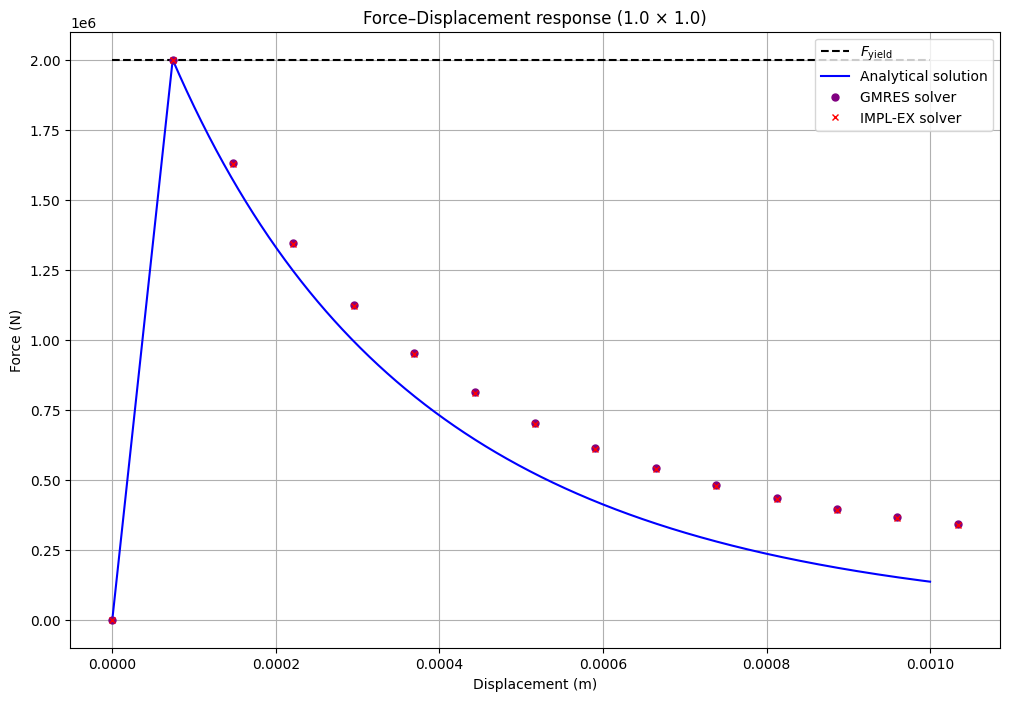

In [51]:
# =====================================================
# 1. Geometry and global parameters
# =====================================================

# Geometry (must match FEM mesh)
Lx = L
Ly = H

# 2D assumption
Thickness = 1.0
CrossSectionArea = Ly * Thickness

# Reference length
L_0 = Lx

# Crack orientation (used in analytical softening)
alpha = 0.0  # radians

# Stress projection vector (Voigt notation)
# Stress vector assumed as: [σ_xx, σ_yy, τ_xy]
n_vector_projection = np.array([1.0, 0.0, 0.0])

# Displacement range
u_values = np.linspace(0.0, 1e-3, 1000)


# =====================================================
# 2. Analytical constitutive response
# =====================================================

def linear_elastic(u):
    """
    Linear elastic stress–displacement relation.
    Must be consistent with Plane Stress / Plane Strain
    assumption used in the FEM stiffness matrix.
    """
    return u * E / ((1 + nu) * (1 - nu) * L_0)


def softening_equilibrium(sigma_xx, u):
    """
    Nonlinear equilibrium equation:
    u_total = u_elastic + u_crack
    """

    # Elastic contribution
    u_el = L_0 * ((1 + nu) * (1 - nu)) / E * sigma_xx

    # Crack opening contribution
    # Derived from: t = σ_y exp(-σ_y/G_f * u_cr)
    # => u_cr = (G_f / σ_y) ln(σ / σ_y)
    u_cr = (G_f / sigma_y) * np.log(sigma_xx / sigma_y) * np.cos(alpha)

    return u_el - u_cr - u


# =====================================================
# 3. Solve analytical response
# =====================================================

sigma_xx_solutions = []

for u in u_values:
    sigma_el = linear_elastic(u)

    # Elastic regime
    if sigma_el <= sigma_y:
        sigma_xx_solutions.append(sigma_el)

    # Softening regime
    else:
        sigma_guess = sigma_xx_solutions[-1] if sigma_xx_solutions else sigma_y

        try:
            sigma_sol = fsolve(
                softening_equilibrium,
                sigma_guess,
                args=(u,)
            )
            sigma_xx_solutions.append(sigma_sol[0])
        except:
            sigma_xx_solutions.append(0.0)

sigma_xx_solutions = np.array(sigma_xx_solutions)

# Convert stress → force
force_analytical = sigma_xx_solutions * CrossSectionArea

print(
    f"Displacement at peak force: "
    f"{u_values[np.argmax(force_analytical)]}"
)


# =====================================================
# 4. Plot analytical and FEM results
# =====================================================

plt.figure(figsize=(12, 8))

# Yield force
plt.plot(
    u_values,
    sigma_y * CrossSectionArea * np.ones_like(u_values),
    linestyle='--',
    color='black',
    label=r'$F_\mathrm{yield}$'
)

# Analytical curve
plt.plot(
    u_values,
    force_analytical,
    color='blue',
    label='Analytical solution'
)

# -----------------------------------------------------
# FEM results (GMRES and IMPL-EX)
# -----------------------------------------------------

for i in range(len(force_states)):

    # NOTE:
    # displacement_states[i][2] assumes a known node index.
    # For robustness, you should identify the node at x = Lx.
    disp_x = displacement_states[i][2]

    # Extract σ_xx from element 0
    fem_sigma_xx = n_vector_projection @ stress_states[i][0]
    fem_force = fem_sigma_xx * CrossSectionArea

    # GMRES
    label = 'GMRES solver' if i == 0 else "_nolegend_"
    plt.plot(
        disp_x,
        fem_force,
        'o',
        color='purple',
        markersize=5,
        label=label
    )

    # IMPL-EX (if available)
    try:
        if i < len(displacement_states_implex):
            disp_x_imp = displacement_states_implex[i][2]
            fem_sigma_xx_imp = (
                n_vector_projection @ stress_states_implex[i][0]
            )
            fem_force_imp = fem_sigma_xx_imp * CrossSectionArea

            label = 'IMPL-EX solver' if i == 0 else "_nolegend_"
            plt.plot(
                disp_x_imp,
                fem_force_imp,
                'x',
                color='red',
                markersize=5,
                label=label
            )
    except NameError:
        pass


# =====================================================
# 5. Final plot formatting
# =====================================================

plt.xlabel('Displacement (m)')
plt.ylabel('Force (N)')
plt.title(f'Force–Displacement response ({Lx} × {Ly})')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [52]:
import pandas as pd

# -------------------------------
# ANALYTICAL DATA
# -------------------------------
df_analytical = pd.DataFrame({
    "Displacement_u": u_values,
    "Stress_sigma_xx": sigma_xx_solutions,
    "Force": force_analytical
})

# -------------------------------
# FEM GMRES DATA
# -------------------------------
fem_disp = []
fem_stress = []
fem_force = []

for i in range(len(force_states)):
    disp_x = displacement_states[i][2]
    stress_xx = n_vector_projection @ stress_states[i][0]
    force = stress_xx * CrossSectionArea

    fem_disp.append(disp_x)
    fem_stress.append(stress_xx)
    fem_force.append(force)

df_fem_gmres = pd.DataFrame({
    "Displacement_u": fem_disp,
    "Stress_sigma_xx": fem_stress,
    "Force": fem_force
})

# -------------------------------
# FEM IMPL-EX DATA (if exists)
# -------------------------------
df_fem_implex = None
if 'displacement_states_implex' in globals():
    fem_disp_imp = []
    fem_stress_imp = []
    fem_force_imp = []

    for i in range(len(displacement_states_implex)):
        disp_x = displacement_states_implex[i][2]
        stress_xx = n_vector_projection @ stress_states_implex[i][0]
        force = stress_xx * CrossSectionArea

        fem_disp_imp.append(disp_x)
        fem_stress_imp.append(stress_xx)
        fem_force_imp.append(force)

    df_fem_implex = pd.DataFrame({
        "Displacement_u": fem_disp_imp,
        "Stress_sigma_xx": fem_stress_imp,
        "Force": fem_force_imp
    })

# -------------------------------
# WRITE TO EXCEL
# -------------------------------
excel_filename = f"force_displacement_results_{lc}.xlsx"

with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:

    df_analytical.to_excel(writer, sheet_name="Analytical", index=False)
    df_fem_gmres.to_excel(writer, sheet_name="FEM_GMRES", index=False)

    if df_fem_implex is not None:
        df_fem_implex.to_excel(writer, sheet_name="FEM_IMPLEX", index=False)

print(f"✅ Data successfully exported to '{excel_filename}'")

✅ Data successfully exported to 'force_displacement_results_0.75.xlsx'


<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3462538492.py:78: SyntaxWarning: invalid escape sequence '\s'
  stress_components = {'$\sigma_{xx}$': s_xx * 1e-6, '$\sigma_{yy}$': s_yy * 1e-6, '$\sigma_{xy}$': s_xy * 1e-6}
/tmp/ipython-input-3462538492.py:78: SyntaxWarning: invalid escape sequence '\s'
  stress_components = {'$\sigma_{xx}$': s_xx * 1e-6, '$\sigma_{yy}$': s_yy * 1e-6, '$\sigma_{xy}$': s_xy * 1e-6}
/tmp/ipython-input-3462538492.py:78: SyntaxWarning: invalid escape sequence '\s'
  stress_components = {'$\sigma_{xx}$': s_xx * 1e-6, '$\sigma_{yy}$': s_yy * 1e-6, '$\sigma_{xy}$': s_xy * 1e-6}


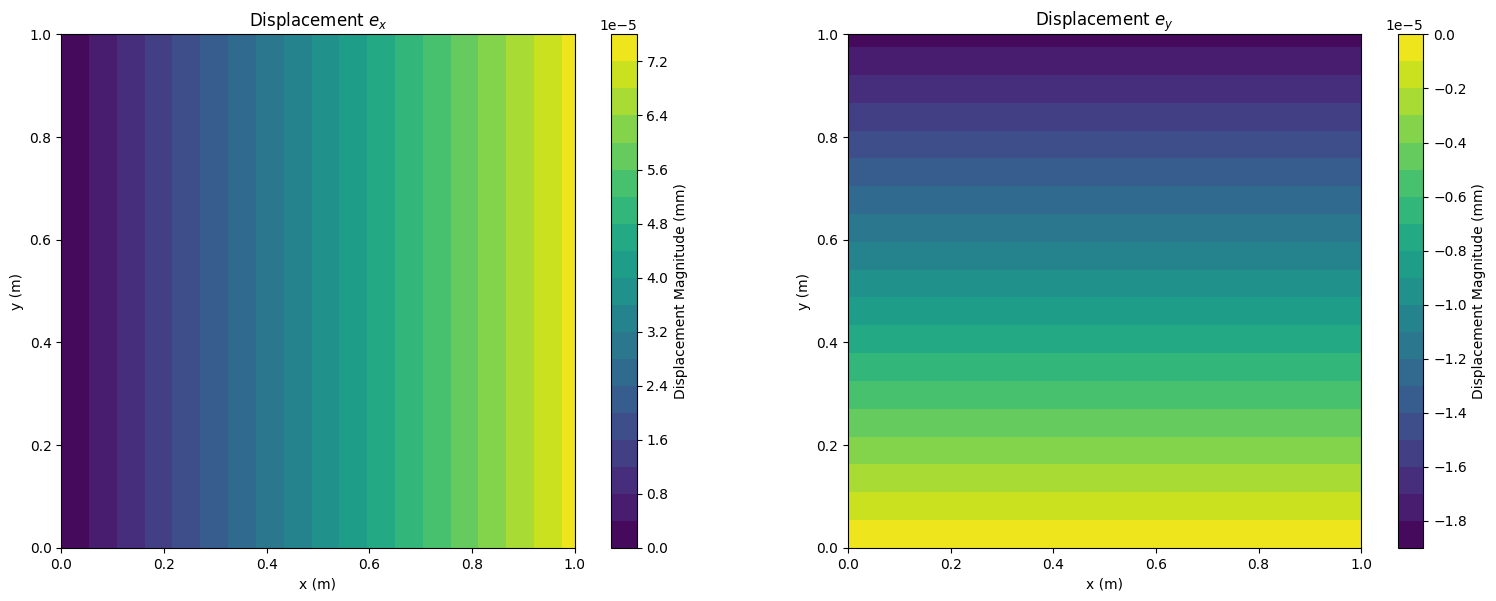

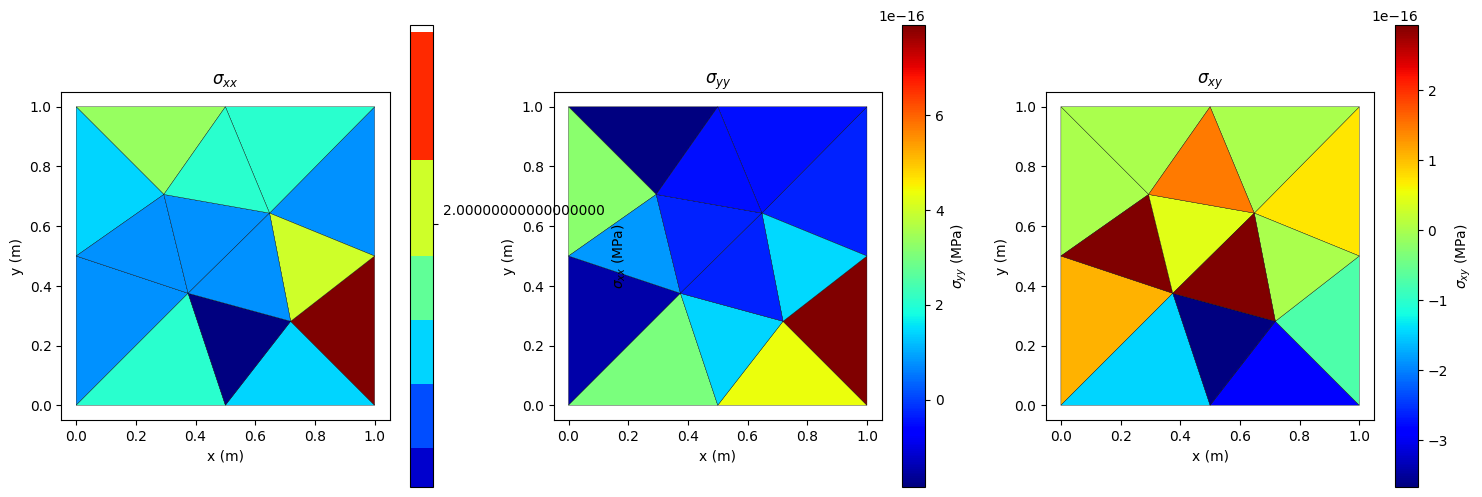

In [53]:
# Plot the displacements
def plot_displacements(frame):
    # Create the triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Compute magnitude of displacements for visualization
    u_x = displacement_states[frame][0::2]   # x-displacement (even indices)
    u_y = displacement_states[frame][1::2]  # y-displacement (odd indices)

    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot x-displacement (e_x)
    contour1 = axes[0].tricontourf(triangulation, u_x, levels=20, cmap='viridis')
    fig.colorbar(contour1, ax=axes[0], label='Displacement Magnitude (mm)')
    axes[0].set_title('Displacement $e_x$')
    axes[0].set_xlabel('x (m)')
    axes[0].set_ylabel('y (m)')
    axes[0].set_aspect('equal', adjustable='box')

    # Plot y-displacement (e_y)
    contour2 = axes[1].tricontourf(triangulation, u_y, levels=20, cmap='viridis')
    fig.colorbar(contour2, ax=axes[1], label='Displacement Magnitude (mm)')
    axes[1].set_title('Displacement $e_y$')
    axes[1].set_xlabel('x (m)')
    axes[1].set_ylabel('y (m)')
    axes[1].set_aspect('equal', adjustable='box')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot the dforce
def plot_force(frame):
    # Create the triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Compute magnitude of displacements for visualization
    f_x = force_states[frame][0::2]  # x-displacement (even indices)
    f_y = force_states[frame][1::2]  # y-displacement (odd indices)

    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot x-displacement (e_x)
    contour1 = axes[0].tricontourf(triangulation, f_x, levels=20, cmap='coolwarm')
    fig.colorbar(contour1, ax=axes[0], label='Force Magnitude (N)')
    axes[0].set_title('Force $e_x$')
    axes[0].set_xlabel('x (m)')
    axes[0].set_ylabel('y (m)')
    axes[0].set_aspect('equal', adjustable='box')

    # Plot y-displacement (e_y)
    contour2 = axes[1].tricontourf(triangulation, f_y, levels=20, cmap='coolwarm')
    fig.colorbar(contour2, ax=axes[1], label='Force Magnitude (N)')
    axes[1].set_title('Force $e_y$')
    axes[1].set_xlabel('x (m)')
    axes[1].set_ylabel('y (m)')
    axes[1].set_aspect('equal', adjustable='box')

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_stress(frame):
    # Compute element centroids for plotting
    element_centroids = np.array([np.mean(nodes[element], axis=0) for element in elements])

    # Create the triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Compute magnitude of displacements for visualization
    s_xx = stress_states[frame][:,0]  # x-displacement (even indices)
    s_yy = stress_states[frame][:,1]  # y-displacement (odd indices)
    s_xy = stress_states[frame][:,2]

    # Plot each stress component
    stress_components = {'$\sigma_{xx}$': s_xx * 1e-6, '$\sigma_{yy}$': s_yy * 1e-6, '$\sigma_{xy}$': s_xy * 1e-6}
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, (name, values) in zip(axes, stress_components.items()):
        tpc = ax.tripcolor(triangulation, facecolors=values, cmap='jet', edgecolors='k')
        fig.colorbar(tpc, ax=ax, label=f'{name} (MPa)')
        ax.set_title(f'{name}')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_aspect('equal', adjustable='box')

plot_displacements(1)
plot_stress(1)

In [54]:
# =====================================================
# Animated visualization of nodal displacements
# =====================================================

# NOTE:
# This animation is designed for Jupyter / Google Colab
# using IPython HTML display.

from IPython.display import HTML


# =====================================================
# 1. Visualization parameters
# =====================================================

# Magnification factor to make displacements visible
# (Purely visual — does NOT affect physics)
DEFORMATION_SCALE = 1000


# =====================================================
# 2. Node deformation function
# =====================================================

def deform_nodes(nodes_coordinates, displacement, scale=DEFORMATION_SCALE):
    """
    Compute deformed node positions.

    Parameters
    ----------
    nodes_coordinates : (N, 2) ndarray
        Original nodal coordinates.
    displacement : (2N,) ndarray
        Global displacement vector [u1x, u1y, u2x, u2y, ...].
    scale : float
        Visualization magnification factor.

    Returns
    -------
    nodes_deformed : (N, 2) ndarray
        Deformed nodal coordinates.
    """

    x_def = nodes_coordinates[:, 0] + scale * displacement[0::2]
    y_def = nodes_coordinates[:, 1] + scale * displacement[1::2]

    return np.column_stack((x_def, y_def))


# =====================================================
# 3. Figure initialization
# =====================================================

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal', adjustable='box')

# Optional: manually fix limits to avoid autoscaling flicker
# ax.set_xlim(-0.2, Lx + 0.2)
# ax.set_ylim(-0.2, Ly + 0.2)


# =====================================================
# 4. Build animation frames
# =====================================================

frames = []

for displacement in displacement_states:
    nodes_deformed = deform_nodes(nodes, displacement)

    # Scatter plot of nodal positions
    scatter = ax.scatter(
        nodes_deformed[:, 0],
        nodes_deformed[:, 1],
        color='black',
        marker='o'
    )

    frames.append([scatter])


# =====================================================
# 5. Create animation object
# =====================================================

anim = animation.ArtistAnimation(
    fig,
    frames,
    interval=100,        # ms between frames
    blit=True,
    repeat_delay=1000
)


# =====================================================
# 6. Additional reference geometry
# =====================================================

# Crack or symmetry line (example: vertical center line)
ax.plot(
    [Lx / 2, Lx / 2],
    [0.0, Ly],
    linestyle='--',
    color='red'
)

ax.set_title('Nodal displacement evolution')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')


# =====================================================
# 7. Display animation in Jupyter
# =====================================================

plt.close(fig)  # Prevent static plot output
HTML(anim.to_jshtml())

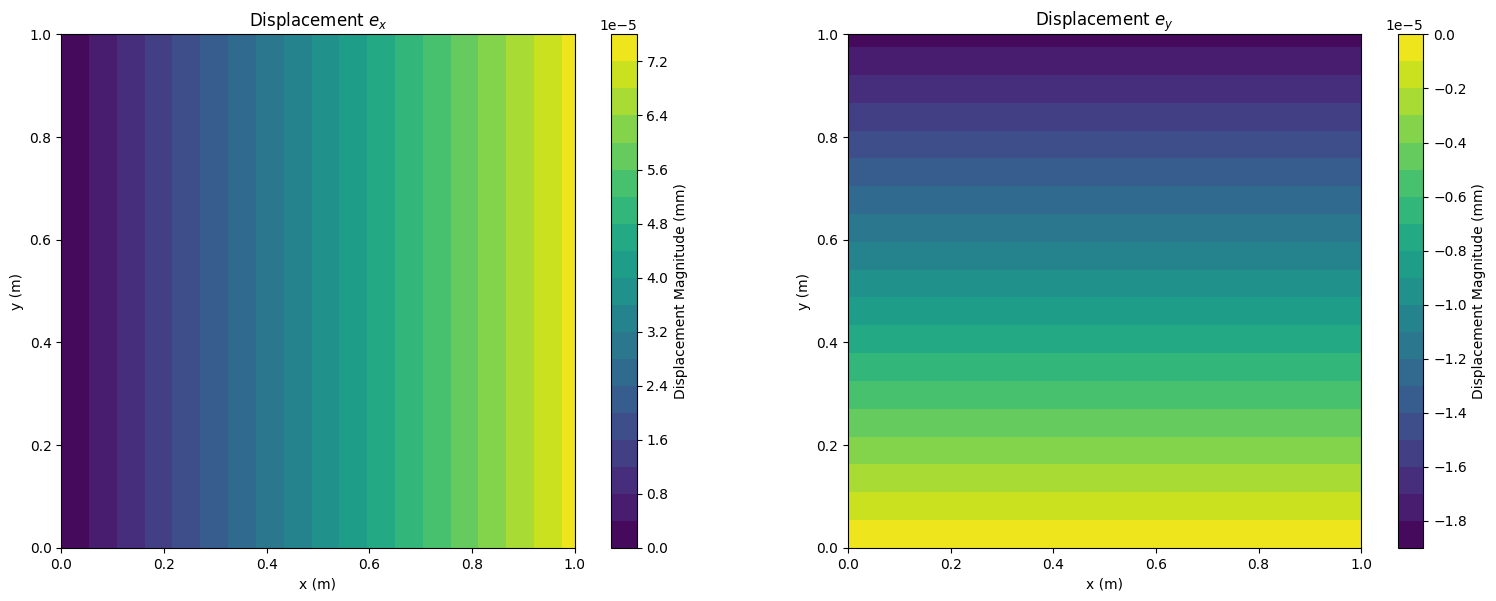

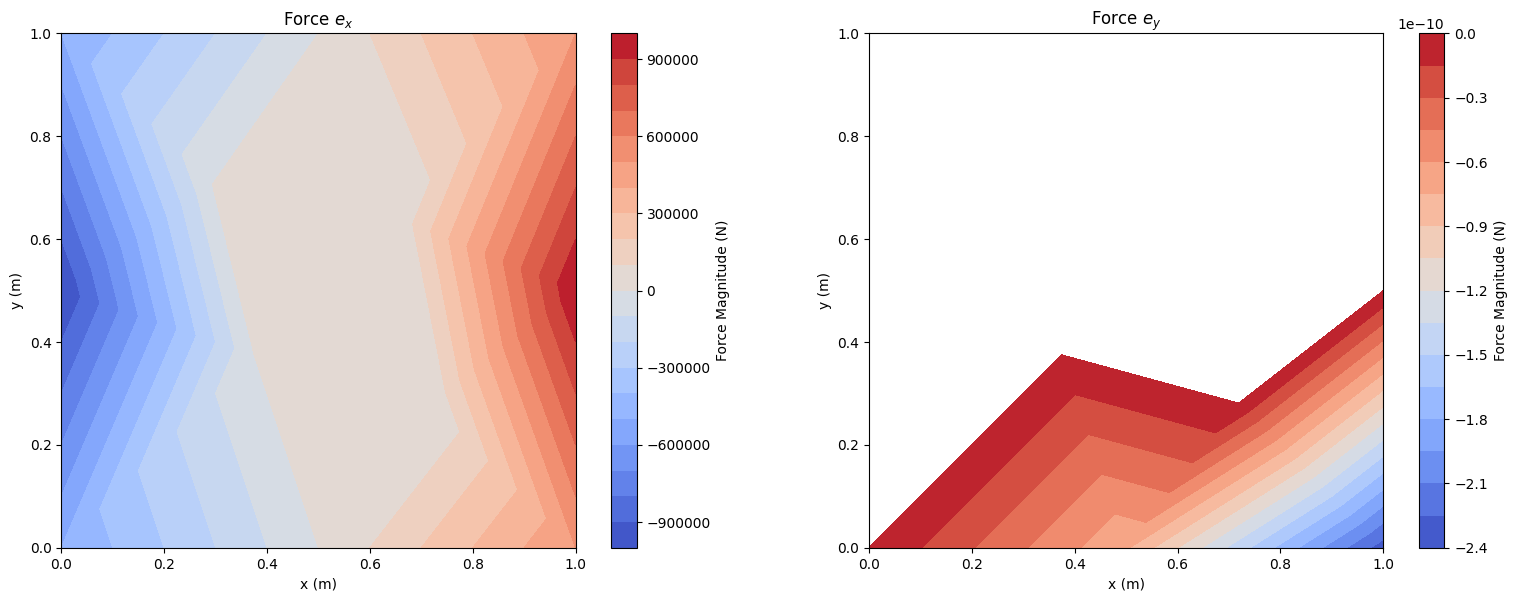

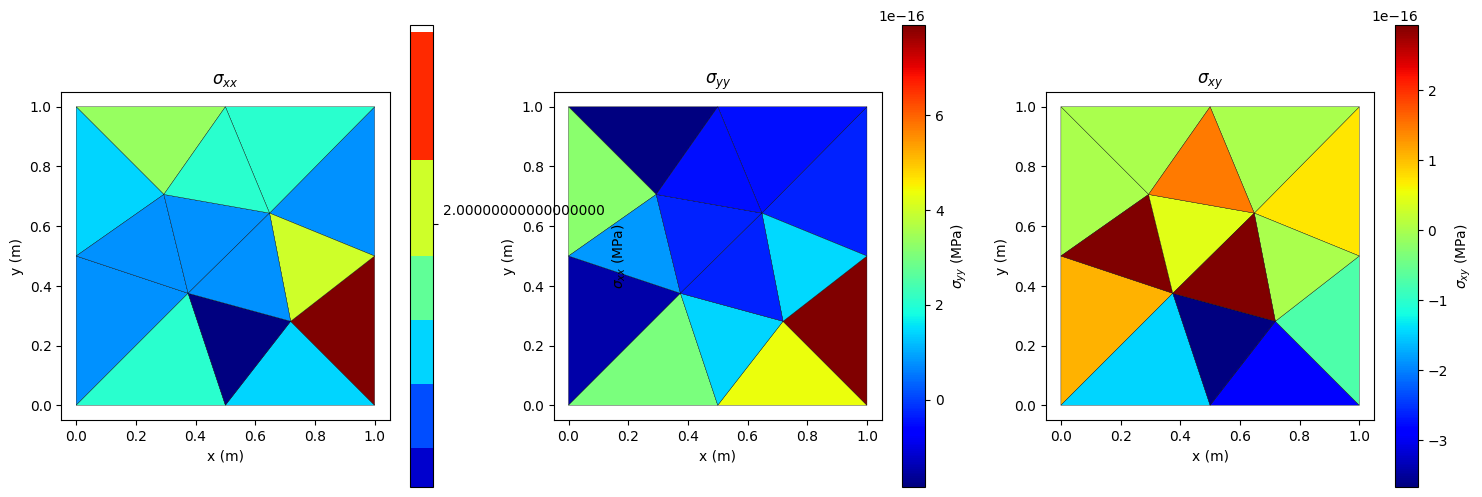

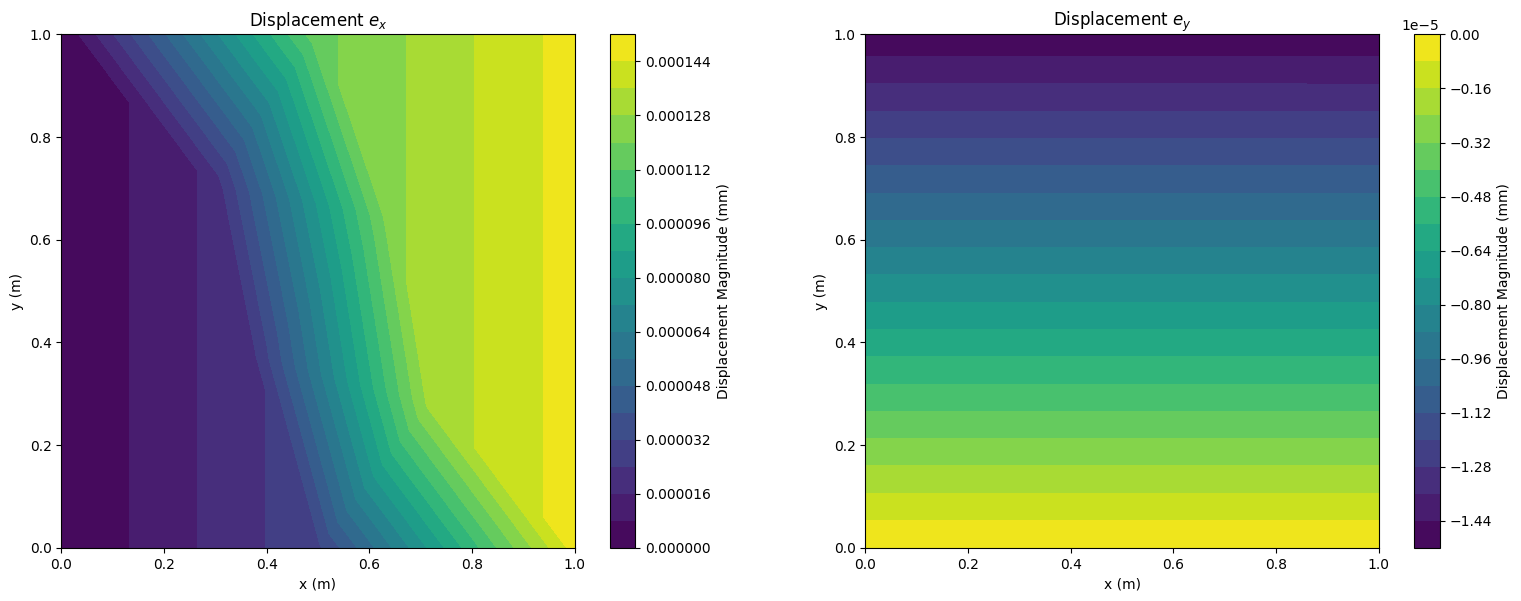

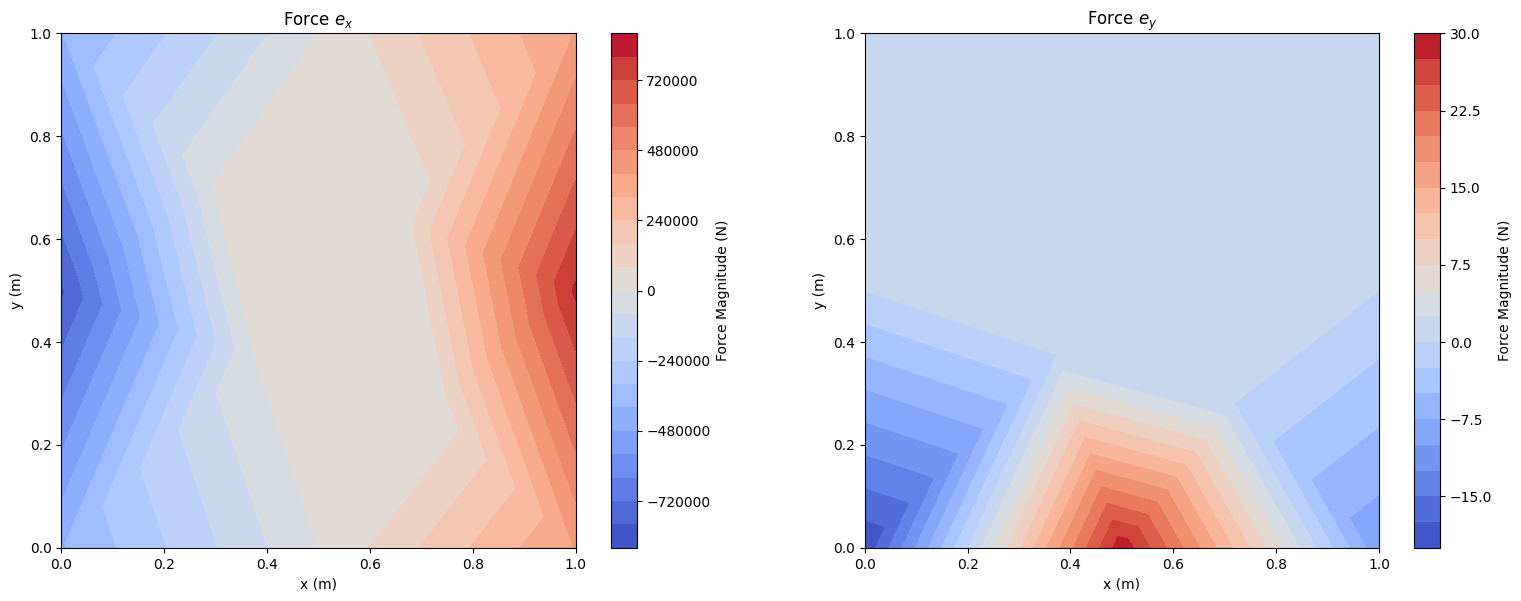

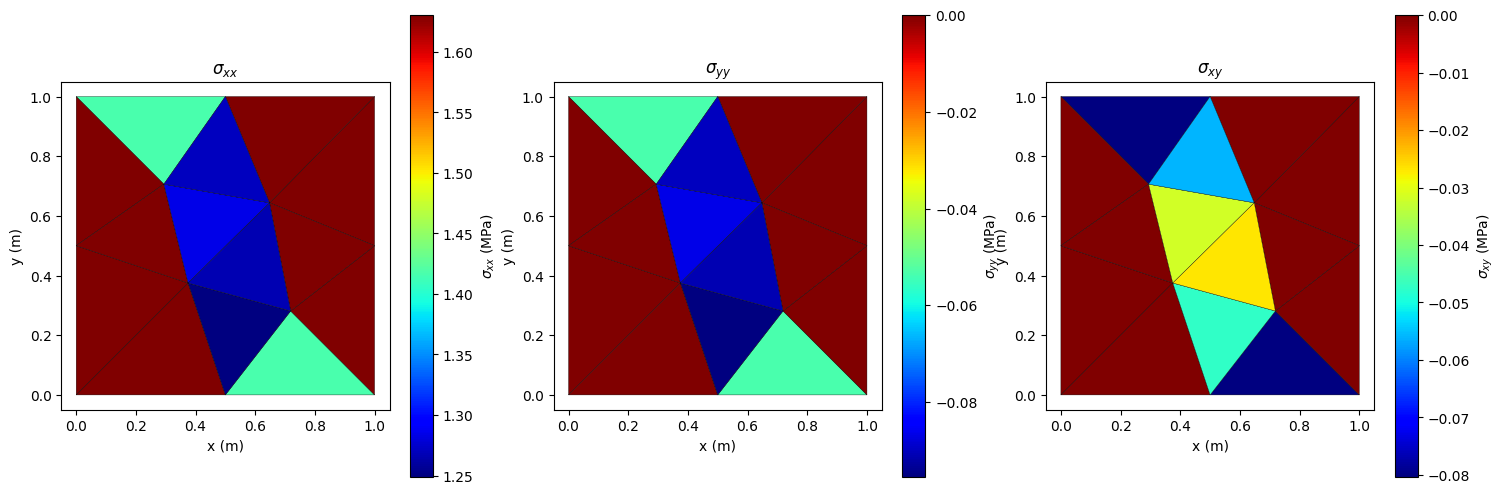

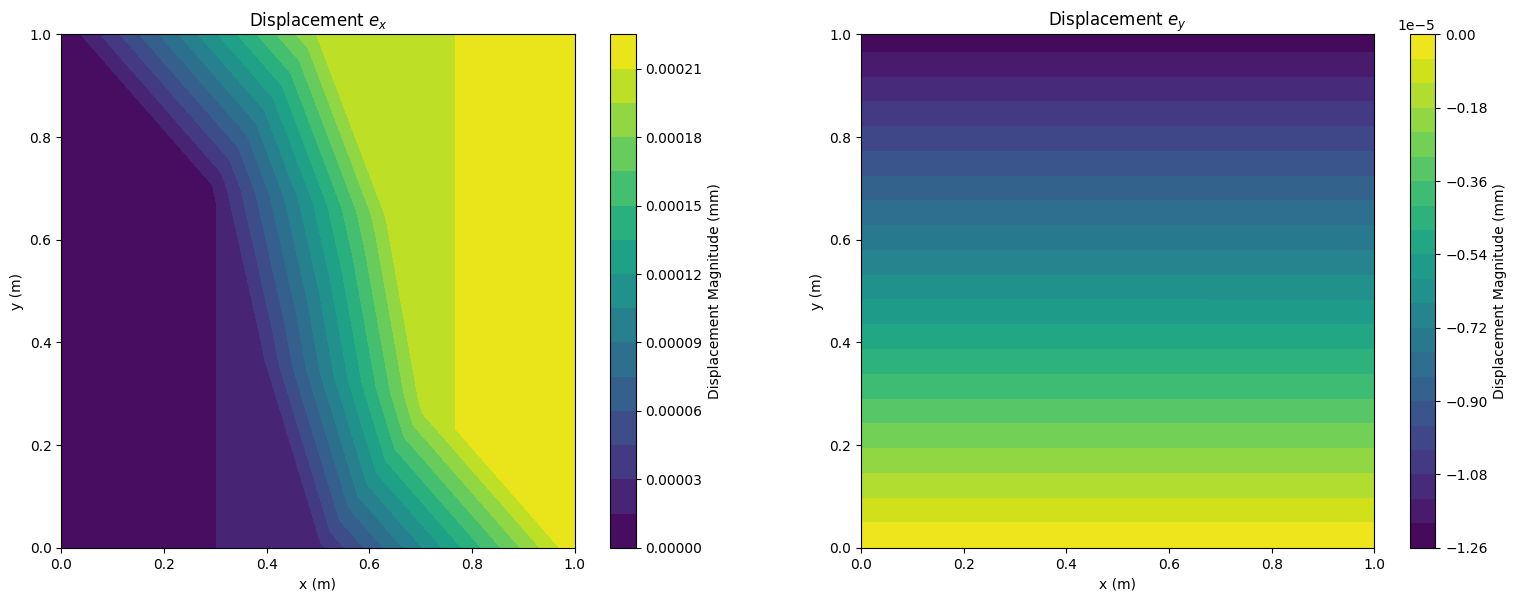

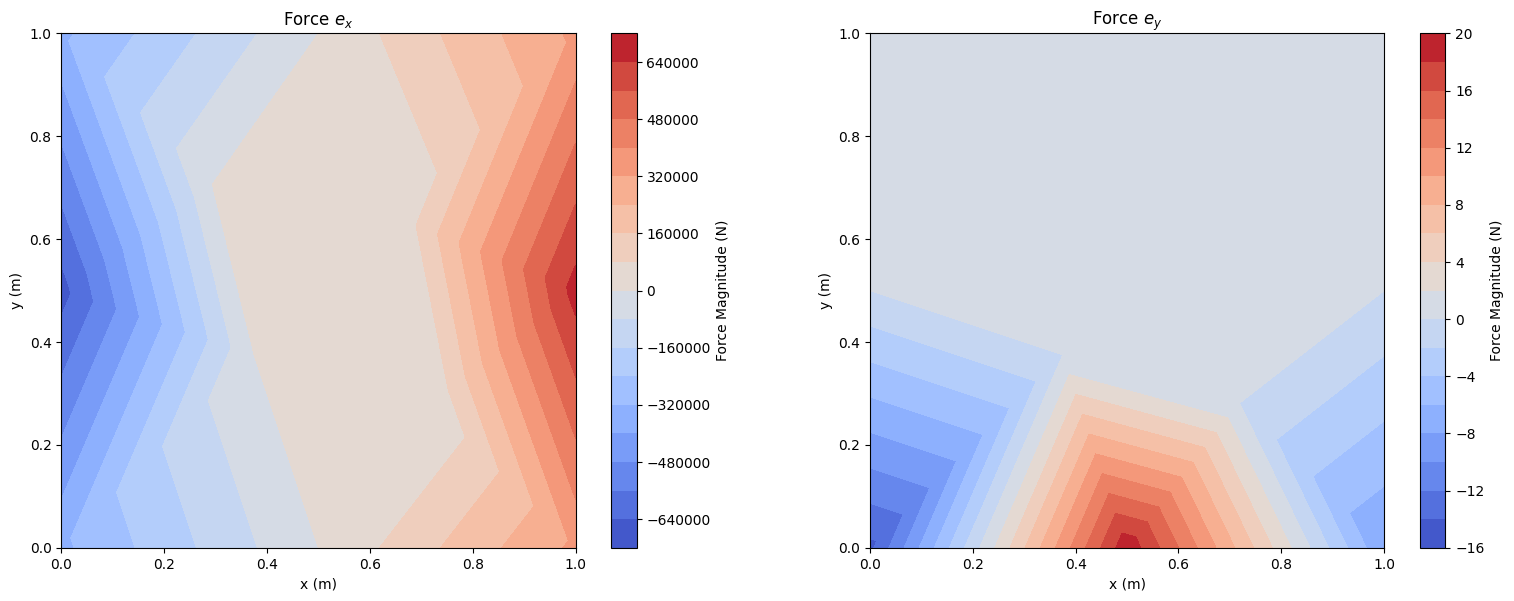

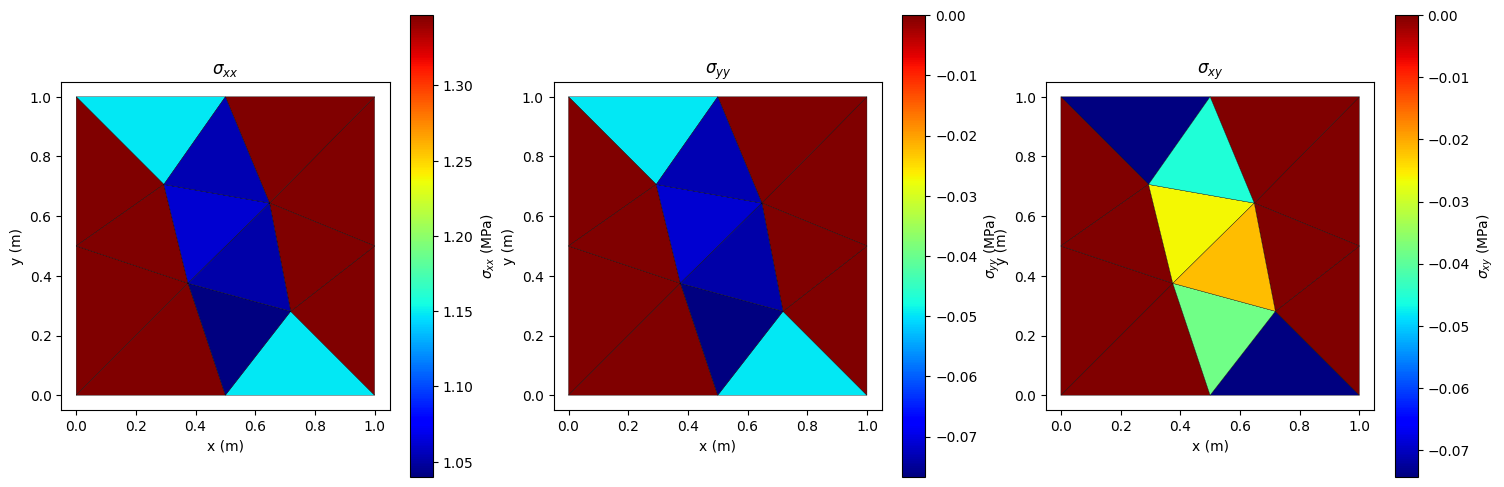

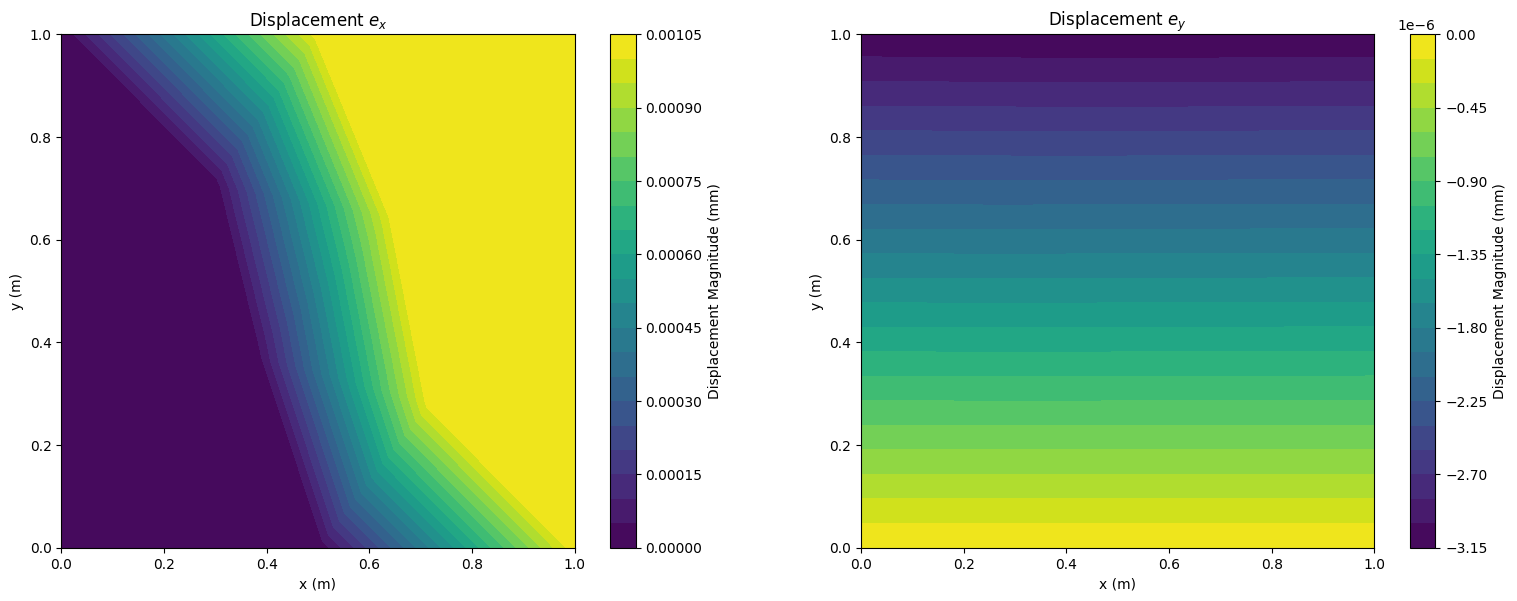

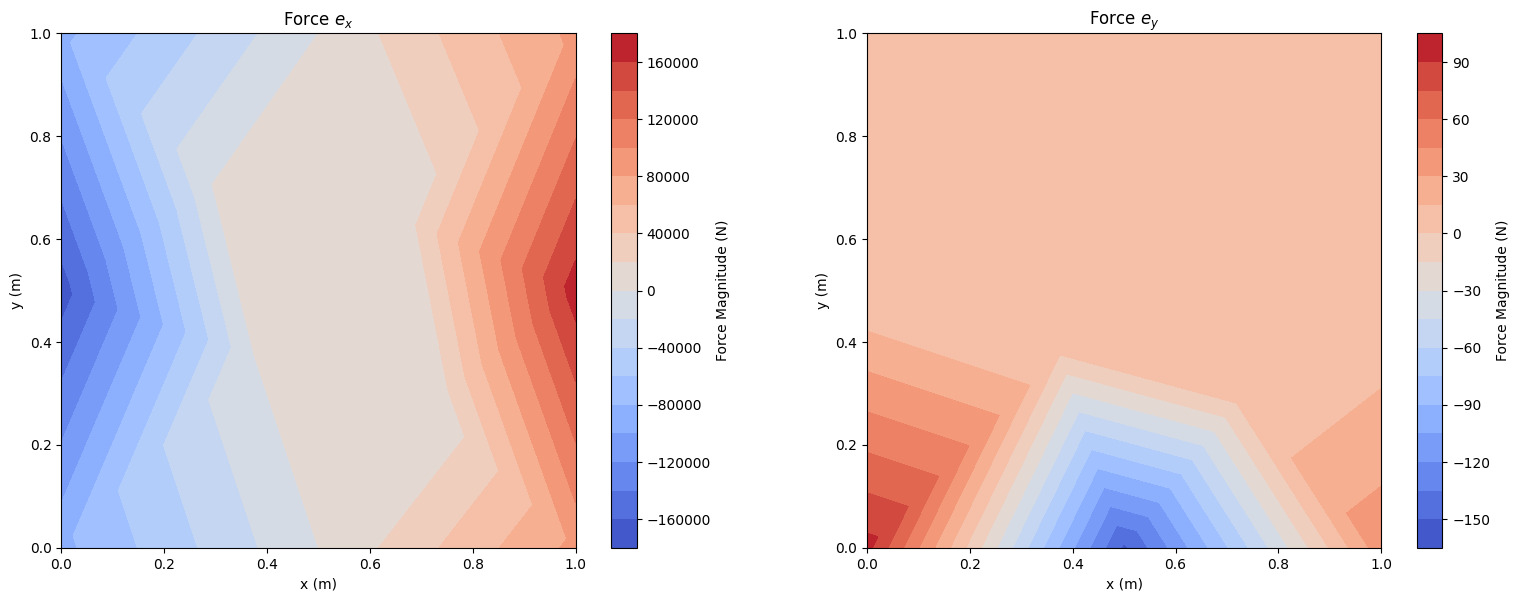

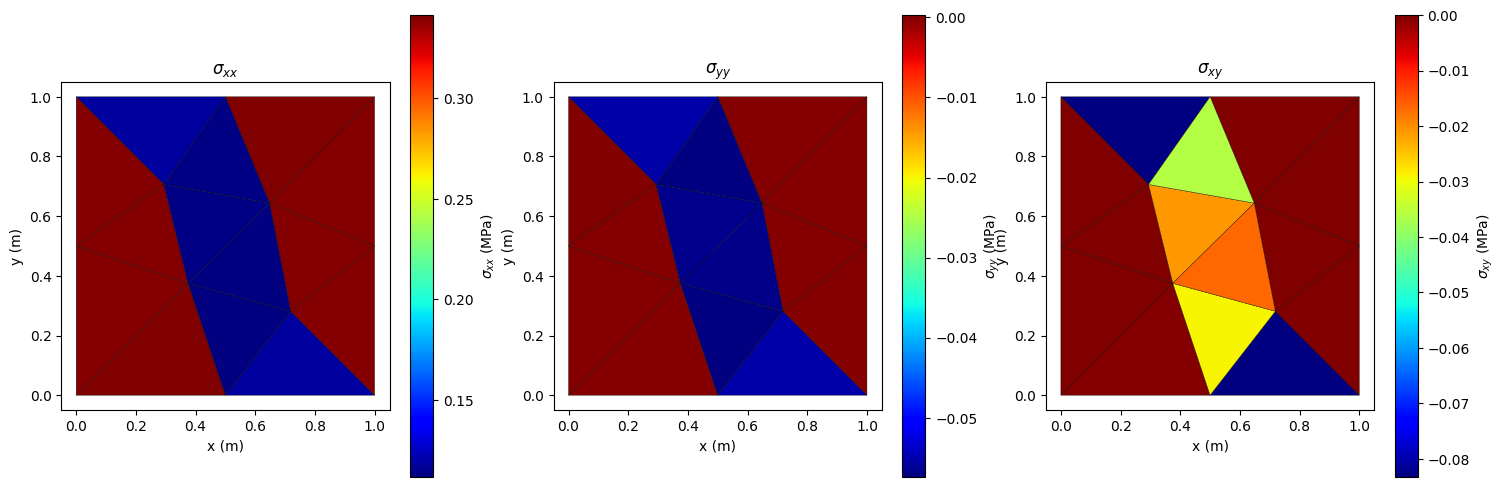

In [55]:
frames = [1, 2, 3, -1]

for frame in frames:
    plot_displacements(frame)
    plot_force(frame)
    plot_stress(frame)